In [1]:
import pickle
import os
import sys
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We build our data set with the help of this parse function

In [2]:
def parse_papers_groupby_newline(file_path):
    
    with open(file_path, 'r',encoding='utf-8') as file:
        paper_blocks = file.read().strip().split("\n\n")
    
    # Initialize list to store paper data
    papers = []
    
    # Process each paper block
    for block in paper_blocks:
        current_paper = {
            "title": None,
            "authors": None,
            "year": None,
            "venue": None,
            "index": None,
            "citations": [],
            "abstract": None,
        }
        # Process lines within the block
        for line in block.split("\n"):
            line = line.strip()
            if line.startswith('#*'):  # Title
                current_paper["title"] = line[2:]
            elif line.startswith('#@'):  # Authors
                current_paper["authors"] = line[2:]
            elif line.startswith('#t'):  # Year
                current_paper["year"] = line[2:]
            elif line.startswith('#c'):  # Venue
                current_paper["venue"] = line[2:]
            elif line.startswith('#index'):  # Index
                current_paper["index"] = line[6:]
            elif line.startswith('#%'):  # Citations
                current_paper["citations"].append(line[2:])
            elif line.startswith('#!'):  # Abstract
                current_paper["abstract"] = line[2:]
            
        papers.append(current_paper)
    
    # Convert to DataFrame
    df = pd.DataFrame(papers)
    df["citations"] = df["citations"].apply(lambda x: ";".join(x) if x else None)
    return df

# Usage
file_path = "Data/papers.txt" 
df = parse_papers_groupby_newline(file_path)

In [3]:
import pandas as pd

def analyze_dataframe(df):
    # Create a summary DataFrame
    summary = {
        "Column": [],
        "Data Type": [],
        "Min Value": [],
        "Max Value": [],
        "Missing Values": []
    }
    
    for column in df.columns:
        summary["Column"].append(column)
        summary["Data Type"].append(df[column].dtype)
        
        if pd.api.types.is_numeric_dtype(df[column]):
            # If column is numeric, calculate min and max
            summary["Min Value"].append(df[column].min())
            summary["Max Value"].append(df[column].max())
        elif pd.api.types.is_datetime64_any_dtype(df[column]):
            # If column is datetime, calculate min and max
            summary["Min Value"].append(df[column].min())
            summary["Max Value"].append(df[column].max())
        else:
            # For non-numeric and non-datetime columns, set min and max as N/A
            summary["Min Value"].append("N/A")
            summary["Max Value"].append("N/A")
        
        # Count missing values
        summary["Missing Values"].append(df[column].isnull().sum())
    
    # Convert summary to a DataFrame for better readability
    summary_df = pd.DataFrame(summary)
    return summary_df

# Usage
analysis = analyze_dataframe(df)
print(analysis)


      Column Data Type Min Value Max Value  Missing Values
0      title    object       N/A       N/A               0
1    authors    object       N/A       N/A               0
2       year    object       N/A       N/A               0
3      venue    object       N/A       N/A               0
4      index    object       N/A       N/A               0
5  citations    object       N/A       N/A          504442
6   abstract    object       N/A       N/A          348734


The major part of articles have no citations: we need to take care about this in order to have a good calssifier; the problem would be that the model could learn that classieng that would have no citazion it's good

Here we dropped the abstract column

In [4]:

df_cleaned = df.drop(columns=['abstract'])
print(df_cleaned.shape)


(629814, 6)


Some code to understant the nature of columns

In [5]:
print("\nNumber of rows where citations are None or empty:")
print(df_cleaned['citations'].isnull().sum())

# Campione di righe con citazioni non vuote
print("\nSample rows with non-empty citations:")
print(df_cleaned[df_cleaned['citations'].notnull()].sample(5))


def count_citations(citation_string):
    if pd.isnull(citation_string):  
        return 0
    else:
        return len(citation_string.split(';'))

df_cleaned['citation_count'] = df_cleaned['citations'].apply(count_citations)

print("\nStatistics on the number of citations per row:")
print(df_cleaned['citation_count'].describe())

print("\nSample rows with multiple citations:")
print(df_cleaned[df_cleaned['citation_count'] > 1].sample(5))



Number of rows where citations are None or empty:
504442

Sample rows with non-empty citations:


                                                    title  \
326097  Analog-testability analysis by determinant-dec...   
20674          Mind the gap: notes on product replacement   
438021  Interior Point Methods for Second-Order Cone P...   
71309   Parallelization of XPath queries using multi-c...   
296169    Lower bounds for linear satisfiability problems   

                                           authors  year  \
326097                    Tao Pi,C.-J. Richard Shi  2000   
20674                                 Pekka Ketola  2006   
438021                Yu-Ju Kuo,Hans D. Mittelmann  2004   
71309   Rajesh Bordawekar,Lipyeow Lim,Oded Shmueli  2009   
296169                               Jeff Erickson  1995   

                                                    venue   index  \
326097  Proceedings of the 2000 Asia and South Pacific...  326097   
20674                                        interactions   20674   
438021        Computational Optimization and Applications  438021

Venue column anlyzed

In [6]:
print("\nNumber of unique values in 'venue':")
print(df_cleaned['venue'].nunique())


print("\nTop 10 most frequent venues:")
print(df_cleaned['venue'].value_counts().head(10))


print("\nNumber of rows where 'venue' is empty or None:")
print(df_cleaned['venue'].isnull().sum())


print("\nSample rows with non-empty 'venue':")
print(df_cleaned[df_cleaned['venue'].notnull()].sample(5))


print("\nStatistical description of the 'venue' column:")
print(df_cleaned['venue'].describe())



Number of unique values in 'venue':
12610

Top 10 most frequent venues:
venue
                                                    98594
Communications of the ACM                            7107
Computer                                             5057
IEEE Transactions on Computers                       3451
Discrete Mathematics                                 3388
Theoretical Computer Science                         3271
Journal of Computational and Applied Mathematics     3091
Microelectronic Engineering                          2903
Journal of Computational Physics                     2897
Fuzzy Sets and Systems                               2794
Name: count, dtype: int64

Number of rows where 'venue' is empty or None:
0

Sample rows with non-empty 'venue':
                                                    title  \
101811              Congestion prediction in early stages   
218387  Controller design for plants with structured u...   
69785          Urban pixels: painting the cit

label encoded on venue

In [7]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()


df_cleaned['venue_encoded'] = label_encoder.fit_transform(df_cleaned['venue'])


print("First few rows with 'venue' and 'venue_encoded':")
print(df_cleaned[['venue', 'venue_encoded']].head())


print("\nNumber of unique values in 'venue':", df_cleaned['venue'].nunique())
print("Number of unique values in 'venue_encoded':", df_cleaned['venue_encoded'].nunique())


venue_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nSample of the venue mapping (original -> encoded):")
print(dict(list(venue_mapping.items())[:10]))


print("\nStatistics for 'venue_encoded':")
print(df_cleaned['venue_encoded'].describe())


First few rows with 'venue' and 'venue_encoded':
                                               venue  venue_encoded
0                                                                 0
1                                                                 0
2  Proceedings of the 6th international workshop ...           8193
3                                                                 0
4                                                                 0

Number of unique values in 'venue': 12610
Number of unique values in 'venue_encoded': 12610

Sample of the venue mapping (original -> encoded):
{'': np.int64(0), '(1987)': np.int64(1), '(1992&ndash;1993)': np.int64(2), '(1993&ndash;1994)': np.int64(3), '(1994 Supplement)': np.int64(4), '(Fall 1991)': np.int64(5), '(Fall/Winter 1991)': np.int64(6), '(February 1987)': np.int64(7), '(February 1991)': np.int64(8), '(Jan./Feb. 1991)': np.int64(9)}

Statistics for 'venue_encoded':
count    629814.000000
mean       4703.601455
std        3950.

The initial dataset contained a large amount of articles, many of which did not have any citations. This posed a significant challenge: including articles without citations in the model would have reduced the ability to correctly predict citation relationships. In fact, articles without citations do not provide any relational information that can be exploited for the prediction task.

Therefore, we decided to filter the articles by selecting only those with a significant number of citations. This approach is based on the assumption that the most cited articles have a relevant role in the citation network and are more representative of the citation dynamics. Including these articles allowed to:

Improve the quality of the dataset: By using articles with relational information (citations), a richer and more informative dataset could be built.
Build a more meaningful model: Focusing on articles with citations improved the model's ability to capture citation relationships, reducing the "noise" caused by articles without connections.
Making a fair comparison: The goal was to create a model that could be compared on a uniform basis, considering articles with sufficient relevance within the citation network.
This choice, while introducing a filter, did not compromise the generalizability of the model, but rather allowed to focus on a representative and informative subset of the dataset. In real scenarios, a similar approach could be justified to focus on key articles that represent the core of the academic network.

In [8]:

most_cited_articles = df_cleaned.nlargest(10000, 'citation_count')

# Debug: Mostra il numero di articoli filtrati e alcune statistiche
print("Number of most cited articles selected:", most_cited_articles.shape[0])
print("\nTop 5 articles by citation count:")
print(most_cited_articles[['index', 'title', 'citation_count', 'year']].head())
print("\nStatistics of citation count for the selected articles:")
print(most_cited_articles['citation_count'].describe())

# Debug: Controlla che non ci siano articoli con citazioni mancanti o anomale
print("\nAre there any articles with missing citation_count?")
print(most_cited_articles['citation_count'].isnull().sum())


Number of most cited articles selected: 10000

Top 5 articles by citation count:
         index                                              title  \
216749  216749    Query evaluation techniques for large databases   
513215  513215              A compendium of key search references   
109762  109762                  A brief survey of program slicing   
304647  304647  Hundreds of impossibility results for distribu...   
517478  517478  An annotated bibliography of computer supporte...   

        citation_count  year  
216749             195  1993  
513215             182  1990  
109762             178  2005  
304647             155  2003  
517478             148  1991  

Statistics of citation count for the selected articles:
count    10000.000000
mean        17.290500
std          8.933034
min         12.000000
25%         13.000000
50%         15.000000
75%         18.000000
max        195.000000
Name: citation_count, dtype: float64

Are there any articles with missing citation_co

In [9]:
from itertools import combinations

def generate_article_pairs_corrected(articles_df):
    pairs = []
    for article_a, article_b in combinations(articles_df.itertuples(), 2):
        
        year_a = int(article_a.year)
        year_b = int(article_b.year)
        if year_a > year_b:  
            pairs.append((article_a.index, article_b.index, year_a, year_b))
        elif year_b > year_a:  
            pairs.append((article_b.index, article_a.index, year_b, year_a))
        
        if len(pairs) >= 10000:
            break
    return pairs
# Ora puoi rieseguire la funzione senza errori.
article_pairs_corrected = generate_article_pairs_corrected(most_cited_articles)

# Debug: Mostra un esempio delle coppie generate
print(f"Number of pairs generated (corrected): {len(article_pairs_corrected)}")
print("\nSample of generated pairs (article_index_A, article_index_B, year_A, year_B):")
print(article_pairs_corrected[:5])


Number of pairs generated (corrected): 10000

Sample of generated pairs (article_index_A, article_index_B, year_A, year_B):
[('216749', '513215', 1993, 1990), ('109762', '216749', 2005, 1993), ('304647', '216749', 2003, 1993), ('216749', '517478', 1993, 1991), ('625521', '216749', 2001, 1993)]


Assumption on the temporal difference between articles:

One of the main assumptions made in building the dataset was to ensure that, for each pair of articles, there was at least one year of difference between their publication dates. This decision is motivated by the fact that, in a real context, it would not make sense to evaluate whether an article cites another that was published later. For an article to cite another, it is necessary that the cited article exists at the time of writing of the article that cites it.

To implement this assumption, the dataset was structured so that each pair of articles respects the following condition:

The publication year of the citing article (A) must be at least one year later than the publication year of the cited article (B).
This choice ensured that the model was built on pairs of articles that represent realistic scenarios. Furthermore, this temporal filter:

Improves the consistency of the dataset: It removes impossible pairs, such as an article that cites another published later.
Mirrors the real-world citation process: Cited articles must exist at the time the citing article was written.
Reduces noise in the data: Ensures that the model learns from plausible temporal relationships.
This assumption was a crucial step in creating a meaningful dataset and ensured that the model was trained on data consistent with the real-world nature of the problem.

In [10]:

def generate_article_pairs_corrected(articles_df):
    pairs = []
    for article_a, article_b in combinations(articles_df.itertuples(), 2):
        
        year_a = int(article_a.year)
        year_b = int(article_b.year)
        if year_a > year_b:  
            pairs.append((article_a.index, article_b.index, year_a, year_b))
        elif year_b > year_a:  
            pairs.append((article_b.index, article_a.index, year_b, year_a))
        
        if len(pairs) >= 10000:
            break
    return pairs


article_pairs_corrected = generate_article_pairs_corrected(most_cited_articles)


print(f"Number of pairs generated (corrected): {len(article_pairs_corrected)}")
print("\nSample of generated pairs (article_index_A, article_index_B, year_A, year_B):")
print(article_pairs_corrected[:5])



Number of pairs generated (corrected): 10000

Sample of generated pairs (article_index_A, article_index_B, year_A, year_B):
[('216749', '513215', 1993, 1990), ('109762', '216749', 2005, 1993), ('304647', '216749', 2003, 1993), ('216749', '517478', 1993, 1991), ('625521', '216749', 2001, 1993)]


Verification if the function has generete the couples corrected

In [11]:

def validate_article_pairs(pairs):
    invalid_pairs = []
    for pair in pairs:
        year_a = pair[2]
        year_b = pair[3]
        
        if not (year_a > year_b or year_b > year_a):
            invalid_pairs.append(pair)
    
    
    print("\nValidation Results:")
    print(f"Total pairs checked: {len(pairs)}")
    print(f"Invalid pairs found: {len(invalid_pairs)}")
    
    if invalid_pairs:
        print("\nSample of invalid pairs:")
        print(invalid_pairs[:5])
    else:
        print("All pairs are valid!")


validate_article_pairs(article_pairs_corrected)



Validation Results:
Total pairs checked: 10000
Invalid pairs found: 0
All pairs are valid!


Here we added all the meaningful features to the pairs

In [12]:

def enrich_article_pairs(pairs, articles_df):
    enriched_pairs = []
    for pair in pairs:
        article_a = articles_df[articles_df['index'] == pair[0]].iloc[0]
        article_b = articles_df[articles_df['index'] == pair[1]].iloc[0]
        enriched_pairs.append({
            'article_a': {
                'index': article_a['index'],
                'title': article_a['title'],
                'authors': article_a['authors'],
                'year': article_a['year'],
                'venue': article_a['venue'],
                'citation_count': article_a['citation_count'],
                'citations': article_a['citations']  
            },
            'article_b': {
                'index': article_b['index'],
                'title': article_b['title'],
                'authors': article_b['authors'],
                'year': article_b['year'],
                'venue': article_b['venue'],
                'citation_count': article_b['citation_count'],
                'citations': article_b['citations']  
            }
        })
    return enriched_pairs


enriched_pairs = enrich_article_pairs(article_pairs_corrected, most_cited_articles)

here we build a small graph for the citatitons in order to get familiar with this topic


Graph Information:
Numero di nodi: 9576
Numero di archi: 10000
Numero di componenti fortemente connessi: 9576


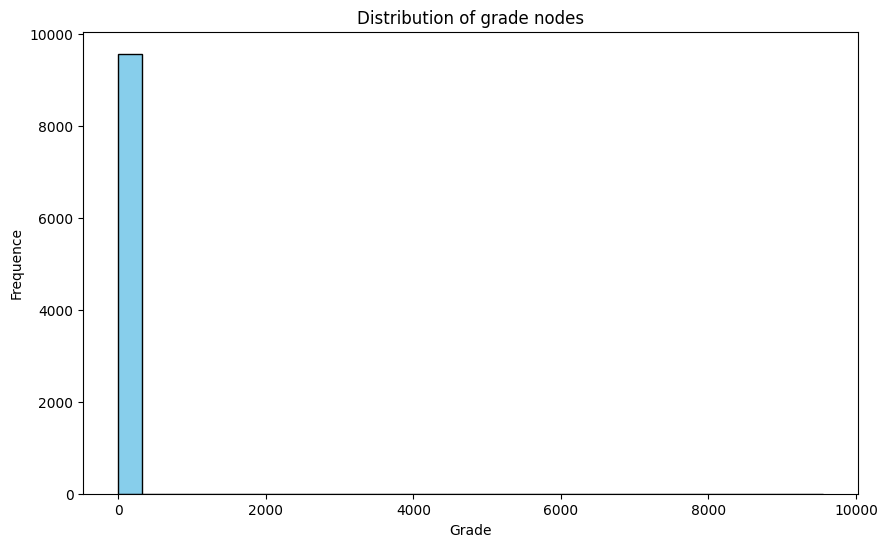

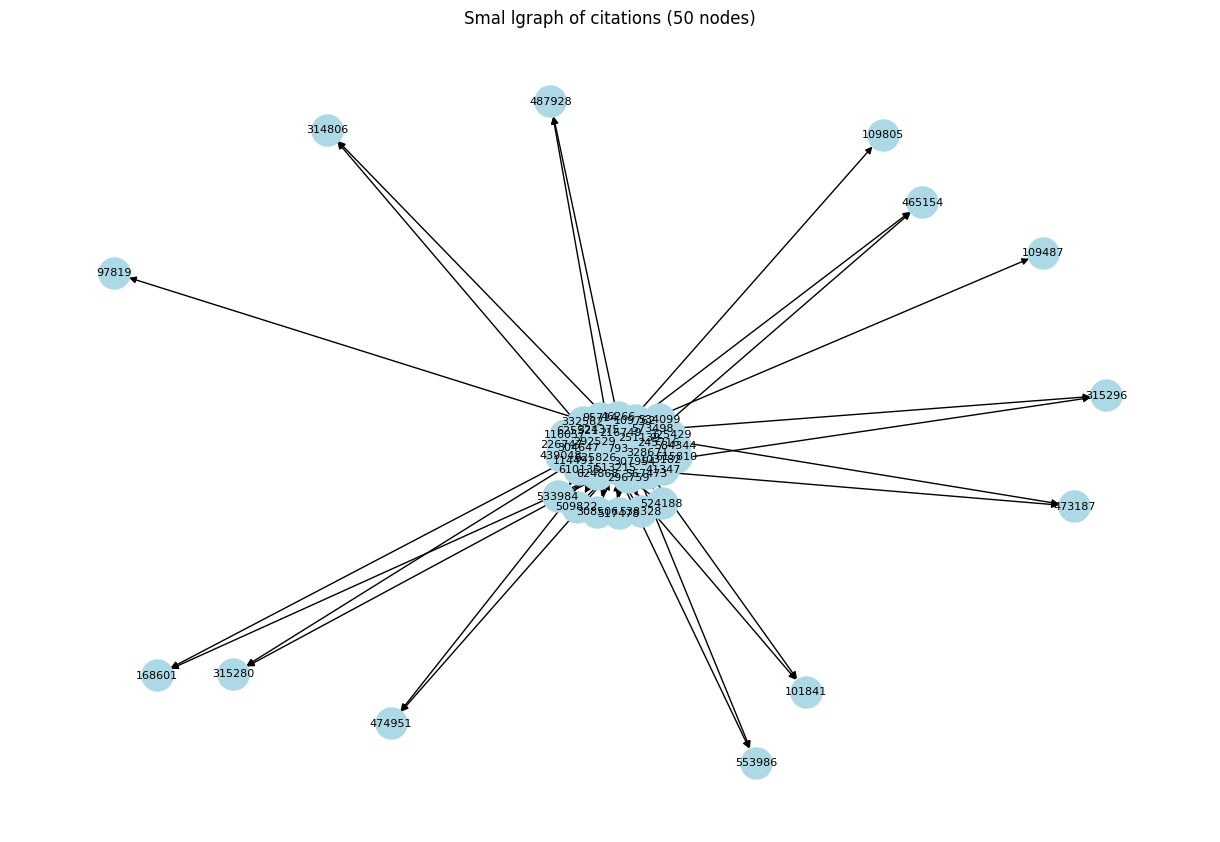

In [13]:
import matplotlib.pyplot as plt
import networkx as nx


def build_citation_graph(pairs):
    graph = nx.DiGraph() 

    
    for pair in pairs:
        graph.add_node(pair['article_a']['index'], 
                       year=pair['article_a']['year'], 
                       citation_count=pair['article_a']['citation_count'])
        graph.add_node(pair['article_b']['index'], 
                       year=pair['article_b']['year'], 
                       citation_count=pair['article_b']['citation_count'])

        
        graph.add_edge(pair['article_a']['index'], pair['article_b']['index'])

    return graph


citation_graph = build_citation_graph(enriched_pairs)


print("\nGraph Information:")
print(f"Numero di nodi: {citation_graph.number_of_nodes()}")
print(f"Numero di archi: {citation_graph.number_of_edges()}")
print(f"Numero di componenti fortemente connessi: {nx.number_strongly_connected_components(citation_graph)}")


degrees = [citation_graph.degree(n) for n in citation_graph.nodes()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of grade nodes")
plt.xlabel("Grade")
plt.ylabel("Frequence")
plt.show()

# Small visulizazion of 50 nodes
subgraph = citation_graph.subgraph(list(citation_graph.nodes)[:50])
plt.figure(figsize=(12, 8))
nx.draw(subgraph, with_labels=True, node_size=500, node_color='lightblue', font_size=8, font_color='black')
plt.title("Smal lgraph of citations (50 nodes)")
plt.show()


We genereted the dataset with labels in order to see if it is balanced or not. The label indicates if the article will citate the other


Sample of dataset with labels:
{'article_a_index': '216749', 'article_b_index': '513215', 'year_a': '1993', 'year_b': '1990', 'citation_count_a': np.int64(195), 'citation_count_b': np.int64(182), 'label': 0}
{'article_a_index': '109762', 'article_b_index': '216749', 'year_a': '2005', 'year_b': '1993', 'citation_count_a': np.int64(178), 'citation_count_b': np.int64(195), 'label': 0}
{'article_a_index': '304647', 'article_b_index': '216749', 'year_a': '2003', 'year_b': '1993', 'citation_count_a': np.int64(155), 'citation_count_b': np.int64(195), 'label': 0}
{'article_a_index': '216749', 'article_b_index': '517478', 'year_a': '1993', 'year_b': '1991', 'citation_count_a': np.int64(195), 'citation_count_b': np.int64(148), 'label': 0}
{'article_a_index': '625521', 'article_b_index': '216749', 'year_a': '2001', 'year_b': '1993', 'citation_count_a': np.int64(130), 'citation_count_b': np.int64(195), 'label': 0}


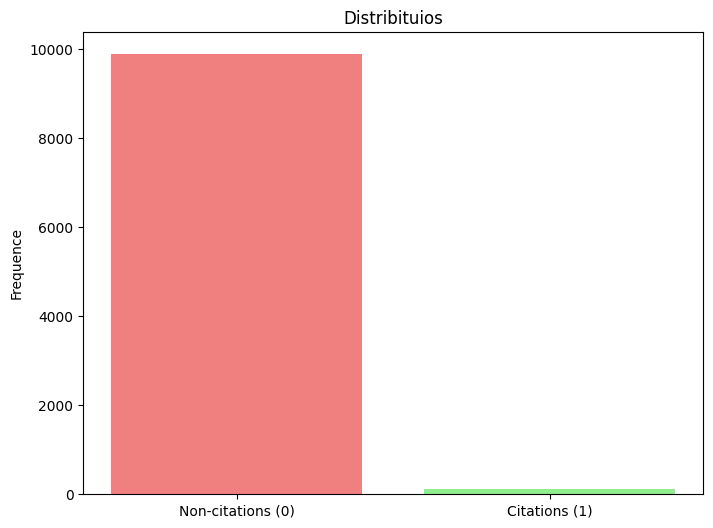

In [14]:

def generate_dataset_with_labels(pairs):
    dataset = []
    for pair in pairs:
        article_a = pair['article_a']
        article_b = pair['article_b']
        
       
        citations_a = article_a['citations']
        if pd.isna(citations_a):  
            citations_a_list = []
        else:
            citations_a_list = citations_a.split(';')
        
        label = 1 if article_b['index'] in citations_a_list else 0
        
        dataset.append({
            'article_a_index': article_a['index'],
            'article_b_index': article_b['index'],
            'year_a': article_a['year'],
            'year_b': article_b['year'],
            'citation_count_a': article_a['citation_count'],
            'citation_count_b': article_b['citation_count'],
            'label': label
        })
    return dataset


dataset_with_labels = generate_dataset_with_labels(enriched_pairs)


print("\nSample of dataset with labels:")
for row in dataset_with_labels[:5]:
    print(row)


labels = [row['label'] for row in dataset_with_labels]
plt.figure(figsize=(8, 6))
plt.bar(['Non-citations (0)', 'Citations (1)'], [labels.count(0), labels.count(1)], color=['lightcoral', 'lightgreen'])
plt.title("Distribituios")
plt.ylabel("Frequence")
plt.show()



As we can see the datacet is very unblaenced: if we train model on that we would not have good rappresentations!

For this resons, we implemented a function that creates balanced couples: half of them will  citate and half of them will note citate the other paper


Sample of balanced dataset:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': '1993', 'year_b': '1988', 'label': 1}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': '1993', 'year_b': '1988', 'label': 1}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': '1993', 'year_b': '1987', 'label': 1}
{'article_a_index': '216749', 'article_b_index': '155485', 'year_a': '1993', 'year_b': '1987', 'label': 1}
{'article_a_index': '216749', 'article_b_index': '156026', 'year_a': '1993', 'year_b': '1985', 'label': 1}


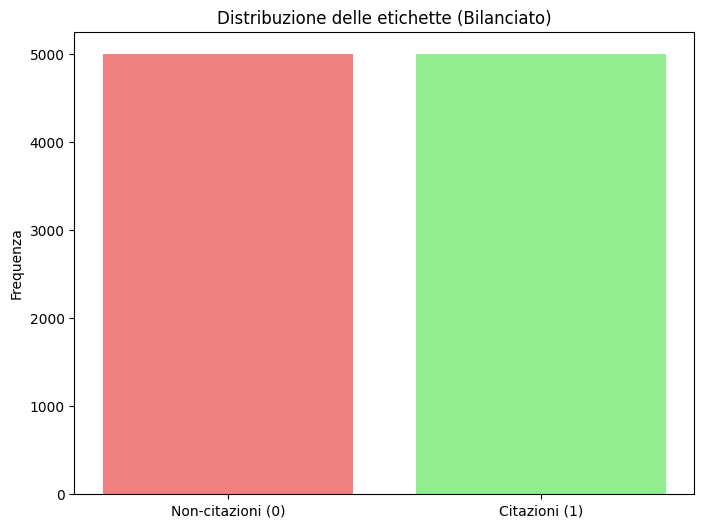

In [15]:
import random

# Step 1: Selezionare coppie con label=1
def generate_positive_pairs(articles_df, max_pairs=5000):
    positive_pairs = []
    for article in articles_df.itertuples():
        if pd.isna(article.citations):  # Salta articoli senza citazioni
            continue
        cited_articles = article.citations.split(';')
        for cited in cited_articles:
            if cited in articles_df['index'].values:
                positive_pairs.append({
                    'article_a_index': article.index,
                    'article_b_index': cited,
                    'year_a': article.year,
                    'year_b': articles_df.loc[articles_df['index'] == cited, 'year'].values[0],
                    'label': 1
                })
                if len(positive_pairs) >= max_pairs:  # Limita a max_pairs
                    return positive_pairs
    return positive_pairs

# Step 2: Selezionare coppie con label=0
def generate_negative_pairs(articles_df, positive_pairs, max_pairs=5000):
    negative_pairs = []
    positive_set = {(pair['article_a_index'], pair['article_b_index']) for pair in positive_pairs}
    indices = list(articles_df['index'])
    while len(negative_pairs) < max_pairs:
        article_a = random.choice(indices)
        article_b = random.choice(indices)
        # Evita coppie già nelle positive_pairs o citazioni reali
        if (article_a != article_b and
            (article_a, article_b) not in positive_set and
            article_b not in articles_df.loc[articles_df['index'] == article_a, 'citations'].values[0].split(';')):
            negative_pairs.append({
                'article_a_index': article_a,
                'article_b_index': article_b,
                'year_a': articles_df.loc[articles_df['index'] == article_a, 'year'].values[0],
                'year_b': articles_df.loc[articles_df['index'] == article_b, 'year'].values[0],
                'label': 0
            })
    return negative_pairs

# Step 3: Generare dataset bilanciato
def generate_balanced_dataset(articles_df):
    positive_pairs = generate_positive_pairs(articles_df, max_pairs=5000)
    negative_pairs = generate_negative_pairs(articles_df, positive_pairs, max_pairs=5000)
    return positive_pairs + negative_pairs

# Generare il dataset bilanciato
balanced_dataset = generate_balanced_dataset(most_cited_articles)

# Debug: Controlla un campione di righe
print("\nSample of balanced dataset:")
for row in balanced_dataset[:5]:
    print(row)

# Visualizzazione: Verifica bilanciamento delle etichette
labels = [row['label'] for row in balanced_dataset]
plt.figure(figsize=(8, 6))
plt.bar(['Non-citazioni (0)', 'Citazioni (1)'], [labels.count(0), labels.count(1)], color=['lightcoral', 'lightgreen'])
plt.title("Distribuzione delle etichette (Bilanciato)")
plt.ylabel("Frequenza")
plt.show()


We reached our intention having balanced couples

Verifyng if couples have at least one year of difference

In [16]:

def validate_year_difference(dataset):
    invalid_pairs = []
    for row in dataset:
        year_a = int(row['year_a'])
        year_b = int(row['year_b'])
        if abs(year_a - year_b) < 1:  
            invalid_pairs.append(row)
    
    print("\nValidation Results:")
    print(f"Total pairs checked: {len(dataset)}")
    print(f"Invalid pairs found: {len(invalid_pairs)}")
    
    if invalid_pairs:
        print("\nSample of invalid pairs:")
        for pair in invalid_pairs[:5]:
            print(pair)
    else:
        print("All pairs satisfy the year difference condition!")


validate_year_difference(balanced_dataset)



Validation Results:
Total pairs checked: 10000
Invalid pairs found: 460

Sample of invalid pairs:
{'article_a_index': '216749', 'article_b_index': '225367', 'year_a': '1993', 'year_b': '1993', 'label': 1}
{'article_a_index': '216749', 'article_b_index': '373976', 'year_a': '1993', 'year_b': '1993', 'label': 1}
{'article_a_index': '304647', 'article_b_index': '311856', 'year_a': '2003', 'year_b': '2003', 'label': 1}
{'article_a_index': '517478', 'article_b_index': '517478', 'year_a': '1991', 'year_b': '1991', 'label': 1}
{'article_a_index': '465154', 'article_b_index': '472871', 'year_a': '1989', 'year_b': '1989', 'label': 1}


We took care about that with the next function


Sample of balanced dataset:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'label': 1}
{'article_a_index': '216749', 'article_b_index': '155485', 'year_a': 1993, 'year_b': 1987, 'label': 1}
{'article_a_index': '216749', 'article_b_index': '156026', 'year_a': 1993, 'year_b': 1985, 'label': 1}


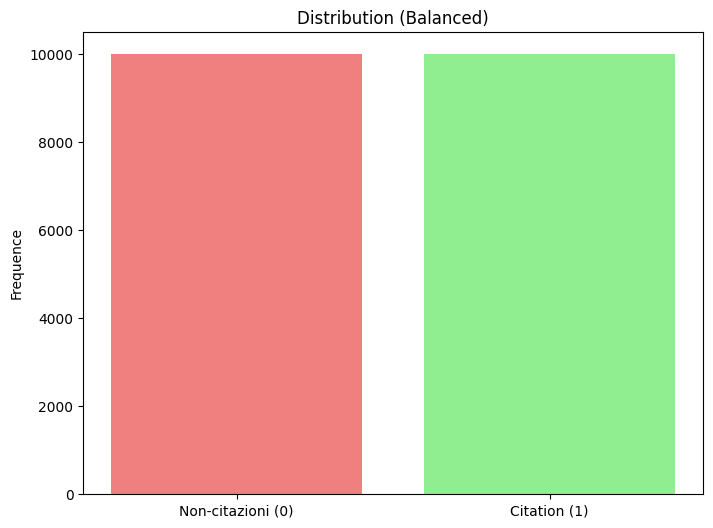

In [17]:
import random

# Step 1: Selezionare coppie con label=1
def generate_positive_pairs(articles_df, max_pairs=10000):
    positive_pairs = []
    article_usage = {index: 0 for index in articles_df['index']}  # Traccia utilizzo degli articoli
    for article in articles_df.itertuples():
        if pd.isna(article.citations):  # Salta articoli senza citazioni
            continue
        cited_articles = article.citations.split(';')
        for cited in cited_articles:
            if cited in articles_df['index'].values:
                year_a = int(article.year)
                year_b = int(articles_df.loc[articles_df['index'] == cited, 'year'].values[0])
                # Controlla la differenza di almeno 1 anno e limita l'uso degli articoli
                if year_a != year_b and article_usage[article.index] < 10 and article_usage[cited] < 10:
                    positive_pairs.append({
                        'article_a_index': article.index,
                        'article_b_index': cited,
                        'year_a': year_a,
                        'year_b': year_b,
                        'label': 1
                    })
                    article_usage[article.index] += 1
                    article_usage[cited] += 1
                    if len(positive_pairs) >= max_pairs:
                        return positive_pairs
    return positive_pairs

# Step 2: Selezionare coppie con label=0
def generate_negative_pairs(articles_df, positive_pairs, max_pairs=10000):
    negative_pairs = []
    positive_set = {(pair['article_a_index'], pair['article_b_index']) for pair in positive_pairs}
    article_usage = {index: 0 for index in articles_df['index']}  # Traccia utilizzo degli articoli
    indices = list(articles_df['index'])
    while len(negative_pairs) < max_pairs:
        article_a = random.choice(indices)
        article_b = random.choice(indices)
        year_a = int(articles_df.loc[articles_df['index'] == article_a, 'year'].values[0])
        year_b = int(articles_df.loc[articles_df['index'] == article_b, 'year'].values[0])
        # Controlla differenza di almeno 1 anno e limita l'uso degli articoli
        if (article_a != article_b and
            year_a != year_b and
            (article_a, article_b) not in positive_set and
            article_usage[article_a] < 10 and article_usage[article_b] < 10):
            negative_pairs.append({
                'article_a_index': article_a,
                'article_b_index': article_b,
                'year_a': year_a,
                'year_b': year_b,
                'label': 0
            })
            article_usage[article_a] += 1
            article_usage[article_b] += 1
    return negative_pairs

# Step 3: Generare dataset bilanciato
def generate_balanced_dataset(articles_df):
    positive_pairs = generate_positive_pairs(articles_df, max_pairs=10000)
    negative_pairs = generate_negative_pairs(articles_df, positive_pairs, max_pairs=10000)
    return positive_pairs + negative_pairs

# Generare il dataset bilanciato
balanced_dataset = generate_balanced_dataset(most_cited_articles)

# Debug: Controlla un campione di righe
print("\nSample of balanced dataset:")
for row in balanced_dataset[:5]:
    print(row)

# Visualizzazione: Verifica bilanciamento delle etichette
labels = [row['label'] for row in balanced_dataset]
plt.figure(figsize=(8, 6))
plt.bar(['Non-citazioni (0)', 'Citation (1)'], [labels.count(0), labels.count(1)], color=['lightcoral', 'lightgreen'])
plt.title("Distribution (Balanced)")
plt.ylabel("Frequence")
plt.show()


Final check

In [18]:
from collections import Counter

# Verifica che tutte le coppie abbiano almeno un anno di differenza
def validate_year_difference_and_usage(dataset):
    invalid_pairs = []
    article_a_usage = Counter()
    article_b_usage = Counter()

    for row in dataset:
        year_a = int(row['year_a'])
        year_b = int(row['year_b'])
        
        # Verifica condizione dell'anno
        if abs(year_a - year_b) < 1:
            invalid_pairs.append(row)
        
        # Conta l'utilizzo degli articoli
        article_a_usage[row['article_a_index']] += 1
        article_b_usage[row['article_b_index']] += 1

    # Output risultati
    print("\nValidation Results:")
    print(f"Total pairs checked: {len(dataset)}")
    print(f"Invalid pairs (year difference < 1): {len(invalid_pairs)}")

    if invalid_pairs:
        print("\nSample of invalid pairs:")
        for pair in invalid_pairs[:5]:
            print(pair)
    else:
        print("All pairs satisfy the year difference condition!")
    
    # Analisi delle ripetizioni degli articoli
    print("\nTop 5 most used articles as article_a:")
    print(article_a_usage.most_common(5))

    print("\nTop 5 most used articles as article_b:")
    print(article_b_usage.most_common(5))

    print(f"\nMaximum times an article was used as article_a: {max(article_a_usage.values())}")
    print(f"Maximum times an article was used as article_b: {max(article_b_usage.values())}")

# Esegui la validazione
validate_year_difference_and_usage(balanced_dataset)


Validation Results:
Total pairs checked: 20000
Invalid pairs (year difference < 1): 0
All pairs satisfy the year difference condition!

Top 5 most used articles as article_a:
[('414069', 15), ('608864', 14), ('513215', 13), ('292529', 13), ('126679', 13)]

Top 5 most used articles as article_b:
[('83376', 14), ('314703', 14), ('599128', 14), ('298280', 14), ('533341', 14)]

Maximum times an article was used as article_a: 15
Maximum times an article was used as article_b: 14


In [19]:
# Controllare un campione casuale delle coppie nel dataset bilanciato
import random

# Mostra 5 campioni casuali
sample_pairs = random.sample(balanced_dataset, 5)
print("\nSample of balanced dataset:")
for pair in sample_pairs:
    print(pair)

# Mostra tutte le chiavi presenti in una coppia
print("\nKeys in a pair:")
print(list(balanced_dataset[0].keys()))



Sample of balanced dataset:
{'article_a_index': '443823', 'article_b_index': '353060', 'year_a': 1989, 'year_b': 2007, 'label': 0}
{'article_a_index': '104989', 'article_b_index': '286851', 'year_a': 2005, 'year_b': 2000, 'label': 0}
{'article_a_index': '47432', 'article_b_index': '341327', 'year_a': 2008, 'year_b': 2007, 'label': 1}
{'article_a_index': '413642', 'article_b_index': '284847', 'year_a': 2007, 'year_b': 2000, 'label': 0}
{'article_a_index': '123734', 'article_b_index': '290360', 'year_a': 2002, 'year_b': 1996, 'label': 1}

Keys in a pair:
['article_a_index', 'article_b_index', 'year_a', 'year_b', 'label']


Now that we ahve verified all these thing, we can enriche our copules with all the features and start to do feature enginerring!

In [20]:
import pandas as pd

# Funzione per generare coppie valide
def create_valid_pairs(df, max_pairs=100000):
    # Ordina il DataFrame per anno
    df_sorted = df.sort_values(by='year')
    
    # Effettua un self-merge per creare coppie
    merged = pd.merge(
        df_sorted, df_sorted,
        how='inner',
        left_index=True,
        right_index=True,
        suffixes=('_A1', '_A2')
    )
    
    # Filtra le coppie per la differenza di almeno un anno
    merged = merged[merged['year_A1'] > merged['year_A2']]
    
    # Mantieni solo le colonne necessarie per le coppie
    valid_pairs = merged[['index_A1', 'index_A2']].rename(columns={'index_A1': 'A1', 'index_A2': 'A2'})
    
    # Campiona fino a max_pairs coppie
    valid_pairs = valid_pairs.sample(n=min(max_pairs, len(valid_pairs)), random_state=42)
    
    return valid_pairs

# Esempio di utilizzo
valid_pairs = create_valid_pairs(df_cleaned, max_pairs=100000)

# Mostra alcune coppie
print(valid_pairs.head())

# Salva in un file CSV (opzionale)
# valid_pairs.to_csv("valid_pairs.csv", index=False)

Empty DataFrame
Columns: [A1, A2]
Index: []


In [21]:

def enrich_balanced_dataset(balanced_dataset, df_cleaned):
    enriched_dataset = []
    df_cleaned_dict = df_cleaned.set_index('index').to_dict(orient='index')  
    
    for pair in balanced_dataset:
        article_a_info = df_cleaned_dict.get(pair['article_a_index'], {})
        article_b_info = df_cleaned_dict.get(pair['article_b_index'], {})
        
        
        enriched_dataset.append({
            **pair,  
            'title_a': article_a_info.get('title', None),
            'authors_a': article_a_info.get('authors', None),
            'venue_a': article_a_info.get('venue', None),
            'title_b': article_b_info.get('title', None),
            'authors_b': article_b_info.get('authors', None),
            'venue_b': article_b_info.get('venue', None),
        })
    
    return enriched_dataset


enriched_balanced_dataset = enrich_balanced_dataset(balanced_dataset, df_cleaned)


print("\nSample of enriched balanced dataset:")
for pair in enriched_balanced_dataset[:5]:
    print(pair)



Sample of enriched balanced dataset:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_a': 'Query evaluation techniques for large databases', 'authors_a': 'Goetz Graefe', 'venue_a': 'ACM Computing Surveys (CSUR)', 'title_b': 'Extended algebra and calculus for nested relational databases', 'authors_b': 'Mark A. Roth,Herry F. Korth,Abraham Silberschatz', 'venue_b': 'ACM Transactions on Database Systems (TODS)'}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_a': 'Query evaluation techniques for large databases', 'authors_a': 'Goetz Graefe', 'venue_a': 'ACM Computing Surveys (CSUR)', 'title_b': 'Implementation concepts for an extensible data model and data language', 'authors_b': 'D. S. Batory,T. Y. Leung,T. E. Wise', 'venue_b': 'ACM Transactions on Database Systems (TODS)'}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'la

# Feature engineering

We started thinking how we can leverage the title. the idea was pretty simple: papers with similar titles is more porbable that cited the other. So we add the cosine similiraty of the titles as a feature

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Calcolare la coseno-similarity tra i titoli
def add_title_similarity(dataset):
    # Estrai i titoli
    titles_a = [row['title_a'] for row in dataset]
    titles_b = [row['title_b'] for row in dataset]

    # Applica TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    all_titles = titles_a + titles_b
    tfidf_matrix = tfidf_vectorizer.fit_transform(all_titles)

    # Divide la matrice in due blocchi (title_a e title_b)
    tfidf_a = tfidf_matrix[:len(titles_a)]
    tfidf_b = tfidf_matrix[len(titles_a):]

    # Calcola la coseno-similarity tra title_a e title_b
    similarities = cosine_similarity(tfidf_a, tfidf_b).diagonal()

    # Aggiungi la similarità al dataset
    for i, row in enumerate(dataset):
        row['title_similarity'] = similarities[i]
    
    # Rimuovi i titoli
    for row in dataset:
        del row['title_a']
        del row['title_b']

    return dataset

# Aggiungi la similarità dei titoli al dataset
enriched_balanced_dataset = add_title_similarity(enriched_balanced_dataset)

# Debug: Controlla un campione del dataset arricchito
print("\nSample of enriched dataset with title similarity:")
for pair in enriched_balanced_dataset[:5]:
    print(pair)



Sample of enriched dataset with title similarity:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'authors_a': 'Goetz Graefe', 'venue_a': 'ACM Computing Surveys (CSUR)', 'authors_b': 'Mark A. Roth,Herry F. Korth,Abraham Silberschatz', 'venue_b': 'ACM Transactions on Database Systems (TODS)', 'title_similarity': np.float64(0.15246013401504716)}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'authors_a': 'Goetz Graefe', 'venue_a': 'ACM Computing Surveys (CSUR)', 'authors_b': 'D. S. Batory,T. Y. Leung,T. E. Wise', 'venue_b': 'ACM Transactions on Database Systems (TODS)', 'title_similarity': np.float64(0.028093112335180293)}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'label': 1, 'authors_a': 'Goetz Graefe', 'venue_a': 'ACM Computing Surveys (CSUR)', 'authors_b': 'Alfons Kemper,Mechtild Wallrath', 'venue_b': 'ACM Computing Surveys (C

`Leveraging Author Information to Improve Citation Prediction`

An important component in the context of academic citations is the relationships between authors. For this reason, we have introduced two types of author features:

Common Authors (common_authors): The presence of shared authors between two articles can indicate a direct connection. Authors tend to cite their own work or that of their collaborators to strengthen arguments or to contextualize their contributions. Therefore, a high number of common authors increases the probability that one article will cite the other.

Author Count Encoding (authors_a_count and authors_b_count): This feature measures the relevance of authors, calculated as the total number of articles associated with each author. Prolific or influential authors are more likely to be cited, and therefore articles associated with these authors gain more weight in predictions.

These features transform qualitative information (author lists) into numerical representations that capture both the direct connection between articles and the broader context of the citation network. This choice improves the model’s ability to exploit relationships between authors to predict whether one article will cite another, adding a layer of understanding that would otherwise be lost.

In [23]:
from collections import Counter

# Funzione per calcolare autori in comune e count encoding
def add_author_features(dataset):
    # Estrai tutti gli autori per il count encoding
    all_authors = []
    for row in dataset:
        if row['authors_a']:
            all_authors.extend(row['authors_a'].split(','))
        if row['authors_b']:
            all_authors.extend(row['authors_b'].split(','))

    # Calcola la frequenza di ciascun autore
    author_counts = Counter(all_authors)

    # Aggiungi le feature al dataset
    for row in dataset:
        # Autori di A e B
        authors_a = set(row['authors_a'].split(',')) if row['authors_a'] else set()
        authors_b = set(row['authors_b'].split(',')) if row['authors_b'] else set()

        # Calcola autori in comune
        row['common_authors'] = len(authors_a & authors_b)

        # Count Encoding: somma le frequenze degli autori di A e B
        row['authors_a_count'] = sum(author_counts[author] for author in authors_a)
        row['authors_b_count'] = sum(author_counts[author] for author in authors_b)

    # Rimuovi i campi originali degli autori
    for row in dataset:
        del row['authors_a']
        del row['authors_b']

    return dataset

# Aggiungi le feature al dataset arricchito
enriched_balanced_dataset = add_author_features(enriched_balanced_dataset)

# Debug: Controlla un campione delle nuove feature
print("\nSample of enriched dataset with author features:")
for pair in enriched_balanced_dataset[:5]:
    print(pair)



Sample of enriched dataset with author features:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'venue_a': 'ACM Computing Surveys (CSUR)', 'venue_b': 'ACM Transactions on Database Systems (TODS)', 'title_similarity': np.float64(0.15246013401504716), 'common_authors': 0, 'authors_a_count': 35, 'authors_b_count': 63}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'venue_a': 'ACM Computing Surveys (CSUR)', 'venue_b': 'ACM Transactions on Database Systems (TODS)', 'title_similarity': np.float64(0.028093112335180293), 'common_authors': 0, 'authors_a_count': 35, 'authors_b_count': 47}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'label': 1, 'venue_a': 'ACM Computing Surveys (CSUR)', 'venue_b': 'ACM Computing Surveys (CSUR)', 'title_similarity': np.float64(0.0), 'common_authors': 0, 'authors_a_count': 35, 'authors_b_count': 48}
{'articl

`Leveraging venue information to improve citation prediction`

Academic venues (e.g., conferences or journals) play a key role in determining the context of an article. Therefore, we introduced two types of venue features:

Common venue (common_venue): When two articles are published in the same venue, one is more likely to cite the other. This is because articles published in the same academic context tend to cover similar topics or belong to the same scientific community.

Venue count encoding (venue_a_count and venue_b_count): This feature measures the popularity or importance of the venue based on the number of articles published there. Larger and more influential venues (such as high-impact journals or top-tier conferences) are more likely to contain articles that cite or are cited by other articles, compared to lesser-known venues.

Rationale
These features leverage the academic context and reputation of venues to improve the model's ability to predict citations. For example:

Shared Venue: Indicates a direct connection between articles based on their academic location.
Count Encoding: Captures the general importance of the venue, reflecting its potential contribution to the citation network.
This information enriches the model by providing broader context, helping it to better distinguish relationships between articles.

In [24]:
from collections import Counter

# Funzione per aggiungere feature delle venue
def add_venue_features(dataset):
    # Estrai tutte le venue per il Count Encoding
    all_venues = []
    for row in dataset:
        if row['venue_a']:
            all_venues.append(row['venue_a'])
        if row['venue_b']:
            all_venues.append(row['venue_b'])

    # Calcola la frequenza di ciascuna venue
    venue_counts = Counter(all_venues)

    # Aggiungi le feature al dataset
    for row in dataset:
        # Venue in comune
        row['common_venue'] = 1 if row['venue_a'] == row['venue_b'] else 0

        # Count Encoding delle venue
        row['venue_a_count'] = venue_counts[row['venue_a']] if row['venue_a'] else 0
        row['venue_b_count'] = venue_counts[row['venue_b']] if row['venue_b'] else 0

    # Rimuovi le colonne originali delle venue
    for row in dataset:
        del row['venue_a']
        del row['venue_b']

    return dataset

# Aggiungi le feature delle venue al dataset
enriched_balanced_dataset = add_venue_features(enriched_balanced_dataset)

# Debug: Controlla un campione delle nuove feature
print("\nSample of enriched dataset with venue features:")
for pair in enriched_balanced_dataset[:5]:
    print(pair)



Sample of enriched dataset with venue features:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': np.float64(0.15246013401504716), 'common_authors': 0, 'authors_a_count': 35, 'authors_b_count': 63, 'common_venue': 0, 'venue_a_count': 1521, 'venue_b_count': 970}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': np.float64(0.028093112335180293), 'common_authors': 0, 'authors_a_count': 35, 'authors_b_count': 47, 'common_venue': 0, 'venue_a_count': 1521, 'venue_b_count': 970}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'label': 1, 'title_similarity': np.float64(0.0), 'common_authors': 0, 'authors_a_count': 35, 'authors_b_count': 48, 'common_venue': 1, 'venue_a_count': 1521, 'venue_b_count': 1521}
{'article_a_index': '216749', 'article_b_index': '155485', 'year_a': 1993, 'year_b': 1987, 'label': 1, '

`Using the difference between years (year_difference)`

We introduced the year_difference feature, which represents the absolute difference between the publication year of the two articles. This feature captures the temporal context of the relationship between the articles.

Added value:
Citation probability:

Articles published closer together in time are more likely to cite each other, as they share the same period of scientific interest.
Too high a temporal difference can reduce this probability, as scientific fields evolve rapidly and older articles may lose relevance.
Plausibility filter:

A difference of at least one year between articles is a logical constraint, as an article cannot cite another published in the same year or later. However, measuring the exact difference adds useful temporal context to the model.
Temporal trends:

Emerging scientific fields may be more likely to cite recent articles. The year_difference feature allows the model to capture this dynamic.
Contribution to the model:
This feature provides crucial temporal information, helping the model to better distinguish between plausible and implausible citations based on their temporal distance.

In [25]:

def add_year_difference(dataset):
    for row in dataset:
        row['year_difference'] = abs(row['year_a'] - row['year_b'])
    return dataset


enriched_balanced_dataset = add_year_difference(enriched_balanced_dataset)


print("\nSample of enriched dataset with year difference:")
for pair in enriched_balanced_dataset[:5]:
    print(pair)



Sample of enriched dataset with year difference:
{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': np.float64(0.15246013401504716), 'common_authors': 0, 'authors_a_count': 35, 'authors_b_count': 63, 'common_venue': 0, 'venue_a_count': 1521, 'venue_b_count': 970, 'year_difference': 5}
{'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': np.float64(0.028093112335180293), 'common_authors': 0, 'authors_a_count': 35, 'authors_b_count': 47, 'common_venue': 0, 'venue_a_count': 1521, 'venue_b_count': 970, 'year_difference': 5}
{'article_a_index': '216749', 'article_b_index': '150894', 'year_a': 1993, 'year_b': 1987, 'label': 1, 'title_similarity': np.float64(0.0), 'common_authors': 0, 'authors_a_count': 35, 'authors_b_count': 48, 'common_venue': 1, 'venue_a_count': 1521, 'venue_b_count': 1521, 'year_difference': 6}
{'article_a_index': '216749', 'articl

# Training a simple model

Dividing in train and test

In [26]:
enriched_balanced_dataset

[{'article_a_index': '216749',
  'article_b_index': '148419',
  'year_a': 1993,
  'year_b': 1988,
  'label': 1,
  'title_similarity': np.float64(0.15246013401504716),
  'common_authors': 0,
  'authors_a_count': 35,
  'authors_b_count': 63,
  'common_venue': 0,
  'venue_a_count': 1521,
  'venue_b_count': 970,
  'year_difference': 5},
 {'article_a_index': '216749',
  'article_b_index': '148975',
  'year_a': 1993,
  'year_b': 1988,
  'label': 1,
  'title_similarity': np.float64(0.028093112335180293),
  'common_authors': 0,
  'authors_a_count': 35,
  'authors_b_count': 47,
  'common_venue': 0,
  'venue_a_count': 1521,
  'venue_b_count': 970,
  'year_difference': 5},
 {'article_a_index': '216749',
  'article_b_index': '150894',
  'year_a': 1993,
  'year_b': 1987,
  'label': 1,
  'title_similarity': np.float64(0.0),
  'common_authors': 0,
  'authors_a_count': 35,
  'authors_b_count': 48,
  'common_venue': 1,
  'venue_a_count': 1521,
  'venue_b_count': 1521,
  'year_difference': 6},
 {'articl

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split

def prepare_model_dataframe(dataset):
    # Convert dataset into a DataFrame
    df = pd.DataFrame(dataset)
    
    feature_columns = ['article_a_index', 'article_b_index', 
                       'title_similarity', 'common_authors', 
                       'authors_a_count', 'authors_b_count',
                       'common_venue', 'venue_a_count', 
                       'venue_b_count', 'year_difference']
    
    # Define features and target variable
    X = df[feature_columns]
    y = df['label']
    
    return X, y


def split_by_unique_papers(df, y, test_size=0.3, random_state=55):
    # Get all unique paper indexes from 'article_a_index' and 'article_b_index'
    all_papers = pd.concat([df['article_a_index'], df['article_b_index']]).unique()
    
    # Split the unique papers into train and test sets
    train_papers, test_papers = train_test_split(all_papers, test_size=test_size, random_state=random_state)
    
    # Create masks to filter rows where either article_a_index or article_b_index are in the train/test sets
    train_mask = df['article_a_index'].isin(train_papers) | df['article_b_index'].isin(train_papers)
    test_mask = df['article_a_index'].isin(test_papers) | df['article_b_index'].isin(test_papers)
    
    # Ensure no overlap in train and test sets
    train_df = df[train_mask & ~test_mask] 
    test_df = df[test_mask & ~train_mask]
    
    # Extract the labels corresponding to the train and test sets
    y_train = y[train_df.index]
    y_test = y[test_df.index]

    # Return the train and test datasets along with their corresponding labels (y)
    return train_df, test_df, y_train, y_test

# Example usage with your enriched dataset
X, y = prepare_model_dataframe(enriched_balanced_dataset)

# Split the data while ensuring no paper overlaps between train and test
X_train, X_test, y_train, y_test= split_by_unique_papers(X, y,test_size=0.3, random_state=42)

print(f"Train set size: {X_train.shape}, Test set size: {X_test.shape}")
print("\nSample of training features:")
X_train.head()


Train set size: (9727, 10), Test set size: (1915, 10)

Sample of training features:


,article_a_index,article_b_index,title_similarity,common_authors,authors_a_count,authors_b_count,common_venue,venue_a_count,venue_b_count,year_difference
10,513215,174368,0.000000,0,20,24,0,29,1521,5
12,513215,318002,0.124854,0,20,10,0,29,1521,16
13,513215,318110,0.019738,0,20,17,0,29,795,6
14,513215,318760,0.000000,0,20,78,0,29,1521,6
16,513215,326075,0.000000,0,20,5,0,29,795,12


Check for data leakage

In [38]:
# Check if there are any overlapping papers between train and test sets
train_papers_a = set(X_train['article_a_index']).union(set(X_train['article_b_index']))
test_papers_a = set(X_test['article_a_index']).union(set(X_test['article_b_index']))

# Find intersection between train and test sets to detect any overlapping papers
overlap_train_test = train_papers_a.intersection(test_papers_a)

if overlap_train_test:
    print("Overlapping papers found between train and test sets:", len(overlap_train_test))
else:
    print("No overlapping papers between train and test sets.")


No overlapping papers between train and test sets.


In [39]:
X_train.drop(columns=['article_a_index', 'article_b_index'], inplace=True)
X_test.drop(columns=['article_a_index', 'article_b_index'], inplace=True)

/var/folders/5q/00jwjrf16r5gnr__8c9_r0wh0000gn/T/ipykernel_10044/951872361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=['article_a_index', 'article_b_index'], inplace=True)
/var/folders/5q/00jwjrf16r5gnr__8c9_r0wh0000gn/T/ipykernel_10044/951872361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns=['article_a_index', 'article_b_index'], inplace=True)


Choose a simple Random Forest classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Funzione per addestrare un modello Random Forest
def train_random_forest(X_train, y_train):
    model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
    model.fit(X_train, y_train)
    return model

# Addestra il modello
rf_model = train_random_forest(X_train, y_train)

# Debug: Controlla l'importanza delle feature
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)



Feature Importances:
            feature  importance
0  title_similarity    0.365067
3   authors_b_count    0.166176
2   authors_a_count    0.151157
6     venue_b_count    0.092667
1    common_authors    0.066576
7   year_difference    0.063534
5     venue_a_count    0.052479
4      common_venue    0.042345


In [41]:
# Valutare il modello
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nAUC-ROC Score:")
    print(roc_auc_score(y_test, y_pred_proba))

    return y_pred, y_pred_proba

# Valutazione
y_pred, y_pred_proba = evaluate_model(rf_model, X_test, y_test)



Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       957
           1       0.82      0.75      0.78       958

    accuracy                           0.79      1915
   macro avg       0.79      0.79      0.79      1915
weighted avg       0.79      0.79      0.79      1915


Confusion Matrix:
[[796 161]
 [238 720]]

AUC-ROC Score:
0.8731301933015274


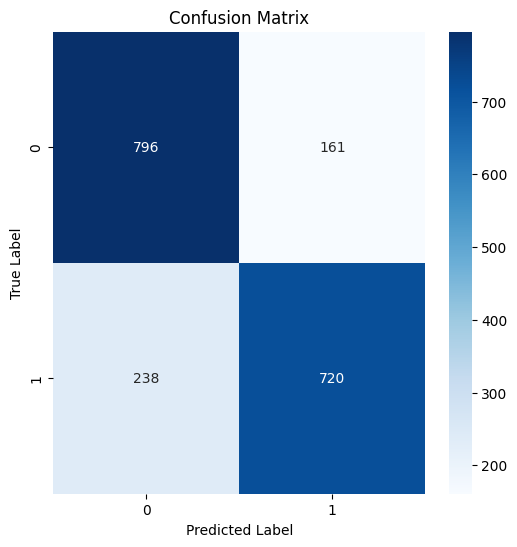

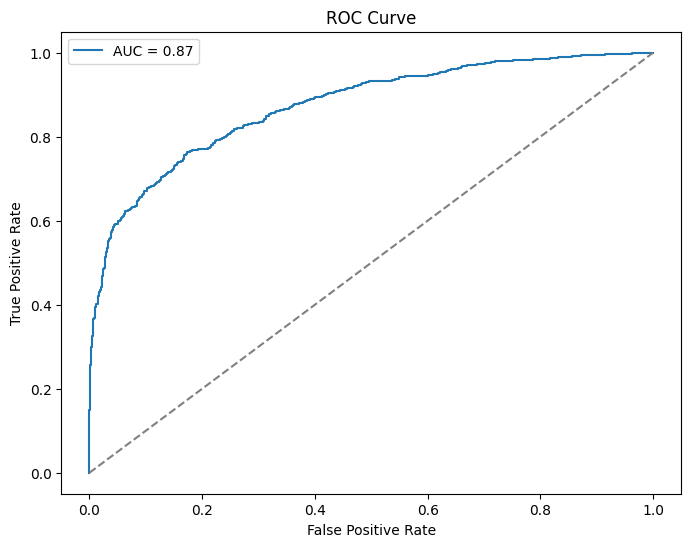

In [42]:
import seaborn as sns
from sklearn.metrics import roc_curve

# Matrice di confusione
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


As we can onserve from the metrics, the result is satisying. taking care to have a balanced dataset and doing a good feature engineering was the key to obtain a good result. the predictions were balanced and the roc curve confirm it

# Graph now

In this code block, we built a citation graph using the enriched dataset. The central idea is to represent each article as a node and each citation relation as a directed edge. This representation allows us to model the problem as a complex network, where nodes (articles) and edges (citations) capture the structural relationships in the dataset.

The reason we chose to use a directed graph (nx.DiGraph) is that the direction of the edges is crucial: an article A can cite an article B, but not the other way around. Therefore, the graph reflects the asymmetric nature of citations, adding important context that would not be visible through traditional features such as text similarity or counts.

The added value of this representation lies in the possibility of exploiting advanced topological metrics, such as degree (in-degree and out-degree), centrality and PageRank, which describe the role and importance of each article in the network. These metrics provide global and relational information that cannot be captured directly by traditional features.

In the context of our final goal, i.e. improving citation prediction, the graph represents a way to enrich the dataset with information derived from the global citation structure. For example, a paper with many incoming edges (high in-degree) may be more likely to receive additional citations, a useful feature to integrate into our model.

Furthermore, visualizing the number of nodes and edges, as well as samples of nodes and edges, allows us to quickly verify that the graph has been correctly constructed and reflects the structure of the dataset. This step is preparatory to extracting advanced graphical features and integrating them into the predictive model.

In [43]:
def split_by_unique_papers(df, y, test_size=0.3, random_state=55):
    # Get all unique paper indexes from 'article_a_index' and 'article_b_index'
    all_papers = pd.concat([df['article_a_index'], df['article_b_index']]).unique()
    
    # Split the unique papers into train and test sets
    train_papers, test_papers = train_test_split(all_papers, test_size=test_size, random_state=random_state)
    
    # Create masks to filter rows where either article_a_index or article_b_index are in the train/test sets
    train_mask = df['article_a_index'].isin(train_papers) | df['article_b_index'].isin(train_papers)
    test_mask = df['article_a_index'].isin(test_papers) | df['article_b_index'].isin(test_papers)
    
    # Ensure no overlap in train and test sets
    train_df = df[train_mask & ~test_mask]  # Filter out rows that are in both train and test
    test_df = df[test_mask & ~train_mask]   # Filter out rows that are in both train and test
    
    # Extract the labels corresponding to the train and test sets
    y_train = y[train_df.index]
    y_test = y[test_df.index]

    # Return the train and test datasets along with their corresponding labels (y)
    return train_df, test_df, y_train, y_test


# Example usage with your enriched dataset
X, y = prepare_model_dataframe(enriched_balanced_dataset)

# Split the data while ensuring no paper overlaps between train and test
X_train, X_test, y_train, y_test = split_by_unique_papers(X, y, test_size=0.3, random_state=42)

# Debug: Check the sizes of the datasets
print(f"Train set size: {X_train.shape}, Test set size: {X_test.shape}")
print(f"y_train size: {y_train.shape}, y_test size: {y_test.shape}")

# Show a sample of training features
print("\nSample of training features:")
X_train.head()

Train set size: (9727, 10), Test set size: (1915, 10)
y_train size: (9727,), y_test size: (1915,)

Sample of training features:


,article_a_index,article_b_index,title_similarity,common_authors,authors_a_count,authors_b_count,common_venue,venue_a_count,venue_b_count,year_difference
10,513215,174368,0.000000,0,20,24,0,29,1521,5
12,513215,318002,0.124854,0,20,10,0,29,1521,16
13,513215,318110,0.019738,0,20,17,0,29,795,6
14,513215,318760,0.000000,0,20,78,0,29,1521,6
16,513215,326075,0.000000,0,20,5,0,29,795,12


In [44]:
pd.concat([X_train, y_train], axis=1)

,article_a_index,article_b_index,title_similarity,common_authors,authors_a_count,authors_b_count,common_venue,venue_a_count,venue_b_count,year_difference,label
10,513215,174368,0.000000,0,20,24,0,29,1521,5,1
12,513215,318002,0.124854,0,20,10,0,29,1521,16,1
13,513215,318110,0.019738,0,20,17,0,29,795,6,1
14,513215,318760,0.000000,0,20,78,0,29,1521,6,1
16,513215,326075,0.000000,0,20,5,0,29,795,12,1
...,...,...,...,...,...,...,...,...,...,...,...
19991,332282,326252,0.000000,0,15,83,0,36,70,2,0
19992,94120,309580,0.000000,0,3,43,0,974,45,6,0
19994,326723,556733,0.148810,0,124,56,0,9,7,2,0
19995,82202,25342,0.012621,0,41,9,0,1510,9,9,0


Check for data leakage

In [45]:
# Check if there are any overlapping papers between train and test sets
train_papers_a = set(X_train['article_a_index']).union(set(X_train['article_b_index']))
test_papers_a = set(X_test['article_a_index']).union(set(X_test['article_b_index']))

# Find intersection between train and test sets to detect any overlapping papers
overlap_train_test = train_papers_a.intersection(test_papers_a)

if overlap_train_test:
    print("Overlapping papers found between train and test sets:", len(overlap_train_test))
else:
    print("No overlapping papers between train and test sets.")


No overlapping papers between train and test sets.


In [46]:
# Funzione per costruire il grafo dalle citazioni
def build_citation_graph_from_training(X_train):
    graph = nx.DiGraph()  # Grafo diretto
    
    # Aggiungi nodi e archi
    for _, row in X_train.iterrows():
        graph.add_node(row.name)  # Nome del nodo corrisponde all'indice
        if 'article_a_index' in row and 'article_b_index' in row:
            graph.add_edge(row['article_a_index'], row['article_b_index'])  # Aggiungi arco diretto
    
    return graph

# Costruire il grafo SOLO dai dati di training
citation_graph_train = build_citation_graph_from_training(X_train)

# Debug: Informazioni sul grafo
print("\nGraph Information:")
print(f"Number of nodes in train graph: {citation_graph_train.number_of_nodes()}")
print(f"Number of edges in train graph: {citation_graph_train.number_of_edges()}")



Graph Information:
Number of nodes in train graph: 15839
Number of edges in train graph: 9725


In [47]:
# Funzione aggiornata per costruire il grafo dalle citazioni
def build_citation_graph_from_training(dataset):
    graph = nx.DiGraph()  # Grafo diretto

    # Aggiungi nodi e archi
    for _, row in dataset.iterrows():
        # Controlla se esistono colonne per gli indici degli articoli
        if 'article_a_index' in row and 'article_b_index' in row:
            graph.add_node(row['article_a_index'])
            graph.add_node(row['article_b_index'])
            graph.add_edge(row['article_a_index'], row['article_b_index'])  # Aggiungi arco diretto
    
    return graph

# Ricostruzione del grafo usando X_train
citation_graph_train = build_citation_graph_from_training(X_train)

# Debug: Informazioni aggiornate sul grafo
print("\nUpdated Graph Information:")
print(f"Number of nodes in train graph: {citation_graph_train.number_of_nodes()}")
print(f"Number of edges in train graph: {citation_graph_train.number_of_edges()}")

# Debug: Stampa i primi 5 archi
print("\nSample edges from train graph:")
print(list(citation_graph_train.edges)[:5])



Updated Graph Information:
Number of nodes in train graph: 6112
Number of edges in train graph: 9725

Sample edges from train graph:
[('513215', '174368'), ('513215', '318002'), ('513215', '318110'), ('513215', '318760'), ('513215', '326075')]


In [48]:
# Verifica delle colonne in X_train
print("\nColumns in X_train:")
display(X_train.columns)

# Campione di righe da X_train per verificare il contenuto
print("\nSample rows from X_train:")
X_train.head()



Columns in X_train:
Index(['article_a_index', 'article_b_index', 'title_similarity',
       'common_authors', 'authors_a_count', 'authors_b_count', 'common_venue',
       'venue_a_count', 'venue_b_count', 'year_difference'],
      dtype='object')

Sample rows from X_train:
   article_a_index article_b_index  title_similarity  common_authors  \
10          513215          174368          0.000000               0   
12          513215          318002          0.124854               0   
13          513215          318110          0.019738               0   
14          513215          318760          0.000000               0   
16          513215          326075          0.000000               0   

    authors_a_count  authors_b_count  common_venue  venue_a_count  \
10               20               24             0             29   
12               20               10             0             29   
13               20               17             0             29   
14              

In [ ]:
# Aggiungi indici al dataset
def prepare_model_dataframe_with_indices(dataset):
    df = pd.DataFrame(dataset)
    
    # Definisci le feature indipendenti e aggiungi gli indici
    feature_columns = [
        'title_similarity', 'common_authors', 'authors_a_count', 'authors_b_count',
        'common_venue', 'venue_a_count', 'venue_b_count', 'year_difference'
    ]
    indices = ['article_a_index', 'article_b_index']
    X = df[feature_columns + indices]  # Aggiungi le colonne degli indici
    y = df['label']  # Target
    
    return X, y
    

# Prepara il dataset con indici
X_with_indices, y_with_indices = prepare_model_dataframe_with_indices(enriched_balanced_dataset)

X_train_with_indices, X_test_with_indices, y_train, y_test = split_by_unique_papers(X_with_indices, y_with_indices, test_size=0.3, random_state=42)


# Debug: Controlla le nuove colonne
print("\nColumns in X_train_with_indices:")
display(X_train_with_indices.columns)

print("\nSample rows from X_train_with_indices:")
X_train_with_indices.head()



Columns in X_train_with_indices:
Index(['title_similarity', 'common_authors', 'authors_a_count',
       'authors_b_count', 'common_venue', 'venue_a_count', 'venue_b_count',
       'year_difference', 'article_a_index', 'article_b_index'],
      dtype='object')

Sample rows from X_train_with_indices:


,title_similarity,common_authors,authors_a_count,authors_b_count,common_venue,venue_a_count,venue_b_count,year_difference,article_a_index,article_b_index
10,0.000000,0,20,24,0,29,1521,5,513215,174368
12,0.124854,0,20,10,0,29,1521,16,513215,318002
13,0.019738,0,20,17,0,29,795,6,513215,318110
14,0.000000,0,20,78,0,29,1521,6,513215,318760
16,0.000000,0,20,5,0,29,795,12,513215,326075


In [50]:
# Funzione per costruire il grafo da un dataset con indici
def build_graph_from_indices(X_data):
    graph = nx.DiGraph()  # Grafo diretto
    
    # Aggiungi nodi e archi
    for _, row in X_data.iterrows():
        graph.add_node(row['article_a_index'])
        graph.add_node(row['article_b_index'])
        graph.add_edge(row['article_a_index'], row['article_b_index'])  # A -> B
    
    return graph

# Costruisci i grafi per train e test separatamente
train_graph = build_graph_from_indices(X_train_with_indices)
test_graph = build_graph_from_indices(X_test_with_indices)

# Debug: Informazioni sui grafi
print("\nTrain Graph Information:")
print(f"Number of nodes: {train_graph.number_of_nodes()}")
print(f"Number of edges: {train_graph.number_of_edges()}")

print("\nTest Graph Information:")
print(f"Number of nodes: {test_graph.number_of_nodes()}")
print(f"Number of edges: {test_graph.number_of_edges()}")

# Visualizza un campione di nodi e archi del grafo di training
print("\nSample nodes from train graph:", list(train_graph.nodes)[:5])
print("Sample edges from train graph:", list(train_graph.edges)[:5])



Train Graph Information:
Number of nodes: 6112
Number of edges: 9725

Test Graph Information:
Number of nodes: 1940
Number of edges: 1915

Sample nodes from train graph: ['513215', '174368', '318002', '318110', '318760']
Sample edges from train graph: [('513215', '174368'), ('513215', '318002'), ('513215', '318110'), ('513215', '318760'), ('513215', '326075')]


In [51]:
# Funzione per calcolare le metriche grafiche
def calculate_graph_metrics(graph):
    # In-degree e out-degree
    in_degree = dict(graph.in_degree())
    out_degree = dict(graph.out_degree())
    
    # Betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(graph)
    
    # PageRank
    pagerank = nx.pagerank(graph)
    
    # Combina tutte le metriche in un dizionario
    metrics = {
        'in_degree': in_degree,
        'out_degree': out_degree,
        'betweenness_centrality': betweenness_centrality,
        'pagerank': pagerank,
    }
    return metrics

# Calcola le metriche per il grafo di training
train_graph_metrics = calculate_graph_metrics(train_graph)

# Debug: Controlla un campione delle metriche
print("\nSample Metrics from Train Graph:")
print(f"In-degree (sample): {list(train_graph_metrics['in_degree'].items())[:5]}")
print(f"Out-degree (sample): {list(train_graph_metrics['out_degree'].items())[:5]}")
print(f"Betweenness centrality (sample): {list(train_graph_metrics['betweenness_centrality'].items())[:5]}")
print(f"PageRank (sample): {list(train_graph_metrics['pagerank'].items())[:5]}")



Sample Metrics from Train Graph:
In-degree (sample): [('513215', 1), ('174368', 5), ('318002', 7), ('318110', 3), ('318760', 4)]
Out-degree (sample): [('513215', 10), ('174368', 1), ('318002', 2), ('318110', 0), ('318760', 4)]
Betweenness centrality (sample): [('513215', 0.00015279700517691308), ('174368', 0.0007052694813168611), ('318002', 0.004189969521965889), ('318110', 0.0), ('318760', 0.0005788328720989391)]
PageRank (sample): [('513215', 0.00016156403346676988), ('174368', 0.00017150073623191457), ('318002', 0.0008699639030531331), ('318110', 0.0001295732066483264), ('318760', 0.0001673504135708058)]


In [52]:
# Combina X_train_with_indices e y_train in un dataset unico
train_data = X_train_with_indices.copy()
train_data['label'] = y_train.values

# Funzione per aggiungere le metriche grafiche al dataset
def add_graph_metrics_to_dataset(dataset, graph_metrics):
    enriched_dataset = []
    for row in dataset.to_dict(orient='records'):  # Converte il DataFrame in un elenco di dizionari
        enriched_row = row.copy()
        
        # Aggiungi metriche grafiche per article_a
        enriched_row['in_degree_a'] = graph_metrics['in_degree'].get(row['article_a_index'], 0)
        enriched_row['out_degree_a'] = graph_metrics['out_degree'].get(row['article_a_index'], 0)
        enriched_row['betweenness_a'] = graph_metrics['betweenness_centrality'].get(row['article_a_index'], 0)
        enriched_row['pagerank_a'] = graph_metrics['pagerank'].get(row['article_a_index'], 0)
        
        # Aggiungi metriche grafiche per article_b
        enriched_row['in_degree_b'] = graph_metrics['in_degree'].get(row['article_b_index'], 0)
        enriched_row['out_degree_b'] = graph_metrics['out_degree'].get(row['article_b_index'], 0)
        enriched_row['betweenness_b'] = graph_metrics['betweenness_centrality'].get(row['article_b_index'], 0)
        enriched_row['pagerank_b'] = graph_metrics['pagerank'].get(row['article_b_index'], 0)
        
        enriched_dataset.append(enriched_row)
    
    return pd.DataFrame(enriched_dataset)  # Converte l'elenco in un DataFrame

# Arricchisci il dataset di training
train_dataset_with_metrics = add_graph_metrics_to_dataset(train_data, train_graph_metrics)

# Debug: Controlla un campione delle righe arricchite
print("\nSample of train dataset with graph metrics:")
train_dataset_with_metrics.head()


Sample of train dataset with graph metrics:


,title_similarity,common_authors,authors_a_count,authors_b_count,common_venue,venue_a_count,venue_b_count,year_difference,article_a_index,article_b_index,label,in_degree_a,out_degree_a,betweenness_a,pagerank_a,in_degree_b,out_degree_b,betweenness_b,pagerank_b
0,0.000000,0,20,24,0,29,1521,5,513215,174368,1,1,10,0.000153,0.000162,5,1,7.052695e-04,0.000172
1,0.124854,0,20,10,0,29,1521,16,513215,318002,1,1,10,0.000153,0.000162,7,2,4.189970e-03,0.000870
2,0.019738,0,20,17,0,29,795,6,513215,318110,1,1,10,0.000153,0.000162,3,0,0.000000e+00,0.000130
3,0.000000,0,20,78,0,29,1521,6,513215,318760,1,1,10,0.000153,0.000162,4,4,5.788329e-04,0.000167
4,0.000000,0,20,5,0,29,795,12,513215,326075,1,1,10,0.000153,0.000162,1,1,3.213866e-07,0.000082


In [53]:
# Calcola le metriche grafiche per il grafo di test
test_graph_metrics = calculate_graph_metrics(test_graph)

# Debug: Controlla un campione delle metriche calcolate
print("\nSample Metrics from Test Graph:")
print(f"In-degree (sample): {list(test_graph_metrics['in_degree'].items())[:5]}")
print(f"Out-degree (sample): {list(test_graph_metrics['out_degree'].items())[:5]}")
print(f"Betweenness centrality (sample): {list(test_graph_metrics['betweenness_centrality'].items())[:5]}")
print(f"PageRank (sample): {list(test_graph_metrics['pagerank'].items())[:5]}")




Sample Metrics from Test Graph:
In-degree (sample): [('216749', 0), ('148419', 2), ('148975', 5), ('155485', 3), ('156026', 4)]
Out-degree (sample): [('216749', 5), ('148419', 1), ('148975', 0), ('155485', 0), ('156026', 0)]
Betweenness centrality (sample): [('216749', 0.0), ('148419', 1.0644577040392443e-06), ('148975', 0.0), ('155485', 0.0), ('156026', 0.0)]
PageRank (sample): [('216749', 0.00028196488699808034), ('148419', 0.0004947345135037555), ('148975', 0.0010510791596045448), ('155485', 0.0008170436191523336), ('156026', 0.0011060797557875925)]


In [54]:
# Combina X_test_with_indices e y_test in un dataset unico
test_data = X_test_with_indices.copy()
test_data['label'] = y_test.values

# Arricchisci il dataset di test con le metriche grafiche
test_dataset_with_metrics = add_graph_metrics_to_dataset(test_data, test_graph_metrics)

# Debug: Controlla un campione delle righe arricchite nel dataset di test
print("\nSample of test dataset with graph metrics:")
test_dataset_with_metrics.head()



Sample of test dataset with graph metrics:


,title_similarity,common_authors,authors_a_count,authors_b_count,common_venue,venue_a_count,venue_b_count,year_difference,article_a_index,article_b_index,label,in_degree_a,out_degree_a,betweenness_a,pagerank_a,in_degree_b,out_degree_b,betweenness_b,pagerank_b
0,0.152460,0,35,63,0,1521,970,5,216749,148419,1,0,5,0.0,0.000282,2,1,0.000001,0.000495
1,0.028093,0,35,47,0,1521,970,5,216749,148975,1,0,5,0.0,0.000282,5,0,0.000000,0.001051
2,0.000000,0,35,14,1,1521,1521,6,216749,155485,1,0,5,0.0,0.000282,3,0,0.000000,0.000817
3,0.000000,0,35,119,1,1521,1521,8,216749,156026,1,0,5,0.0,0.000282,4,0,0.000000,0.001106
4,0.000000,0,35,31,1,1521,1521,6,216749,170890,1,0,5,0.0,0.000282,2,2,0.000001,0.000450


In [66]:
train_dataset_with_metrics.columns

Index(['title_similarity', 'common_authors', 'authors_a_count',
       'authors_b_count', 'common_venue', 'venue_a_count', 'venue_b_count',
       'year_difference', 'article_a_index', 'article_b_index', 'label',
       'in_degree_a', 'out_degree_a', 'betweenness_a', 'pagerank_a',
       'in_degree_b', 'out_degree_b', 'betweenness_b', 'pagerank_b'],
      dtype='object')

In [ ]:
# Preparazione dei dati per il modello
def prepare_final_model_dataframe(dataset):
    df = pd.DataFrame(dataset)

    # Seleziona tutte le feature, inclusi i grafi
    feature_columns = [
        'title_similarity', 'common_authors', 'authors_a_count', 'authors_b_count',
        'common_venue', 'venue_a_count', 'venue_b_count', 'year_difference',
        'in_degree_a', 'out_degree_a', 'betweenness_a', 'pagerank_a',
        'in_degree_b', 'out_degree_b', 'betweenness_b', 'pagerank_b'
    ]
    X = df[feature_columns]  # Feature indipendenti
    y = df['label']          # Target

    return X, y

# Prepara i dati per train e test
X_train_final, y_train_final = prepare_final_model_dataframe(train_dataset_with_metrics)
X_test_final, y_test_final = prepare_final_model_dataframe(test_dataset_with_metrics)

# Debug: Controlla un campione dei dati di training
print("\nTrain dataset sample:")
X_train_final.head()



Train dataset sample:


,title_similarity,common_authors,authors_a_count,authors_b_count,common_venue,venue_a_count,venue_b_count,year_difference,in_degree_a,out_degree_a,betweenness_a,pagerank_a,in_degree_b,out_degree_b,betweenness_b,pagerank_b
0,0.000000,0,20,24,0,29,1521,5,1,10,0.000153,0.000162,5,1,7.052695e-04,0.000172
1,0.124854,0,20,10,0,29,1521,16,1,10,0.000153,0.000162,7,2,4.189970e-03,0.000870
2,0.019738,0,20,17,0,29,795,6,1,10,0.000153,0.000162,3,0,0.000000e+00,0.000130
3,0.000000,0,20,78,0,29,1521,6,1,10,0.000153,0.000162,4,4,5.788329e-04,0.000167
4,0.000000,0,20,5,0,29,795,12,1,10,0.000153,0.000162,1,1,3.213866e-07,0.000082


In [67]:
# Concatenare i dati di train e test
train_dataset_with_metrics.to_pickle('data_created/train_final_dataset.pkl')
test_dataset_with_metrics.to_pickle('data_created/test_final_dataset.pkl')

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per addestrare il modello Random Forest
def train_random_forest_final(X_train, y_train):
    model = RandomForestClassifier(random_state=55, n_estimators=100, max_depth=10)
    model.fit(X_train, y_train)
    return model

# Addestra il modello con le nuove feature
rf_final_model = train_random_forest_final(X_train_final, y_train_final)

# Debug: Importanza delle feature
feature_importances_final = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': rf_final_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances_final)



Feature Importances:
             feature  importance
0   title_similarity    0.257656
9       out_degree_a    0.181971
12       in_degree_b    0.169718
3    authors_b_count    0.071085
2    authors_a_count    0.061382
1     common_authors    0.042496
7    year_difference    0.038890
15        pagerank_b    0.034473
6      venue_b_count    0.034085
5      venue_a_count    0.023074
4       common_venue    0.022909
10     betweenness_a    0.015395
11        pagerank_a    0.015155
14     betweenness_b    0.013821
13      out_degree_b    0.009671
8        in_degree_a    0.008219


In [57]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Funzione per valutare il modello
def evaluate_final_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"\nAUC-ROC Score: {auc_score:.2f}")

    return y_pred, y_pred_proba

# Valutazione del modello
y_pred_final, y_pred_proba_final = evaluate_final_model(rf_final_model, X_test_final, y_test_final)



Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.96      0.82       957
           1       0.93      0.63      0.75       958

    accuracy                           0.79      1915
   macro avg       0.83      0.79      0.79      1915
weighted avg       0.83      0.79      0.79      1915


Confusion Matrix:
[[915  42]
 [356 602]]

AUC-ROC Score: 0.90


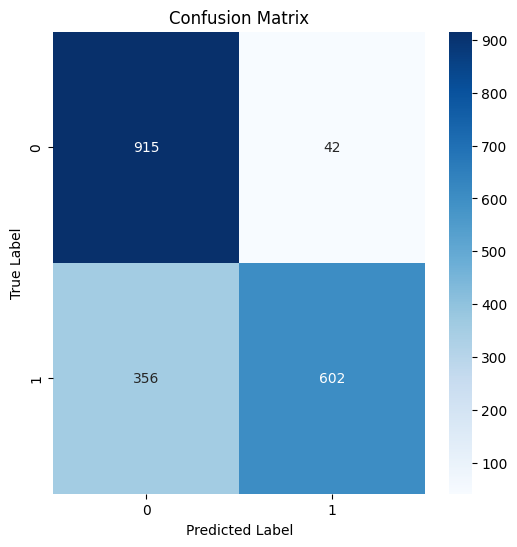

In [58]:
# Matrice di confusione
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_final, y_pred_final), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


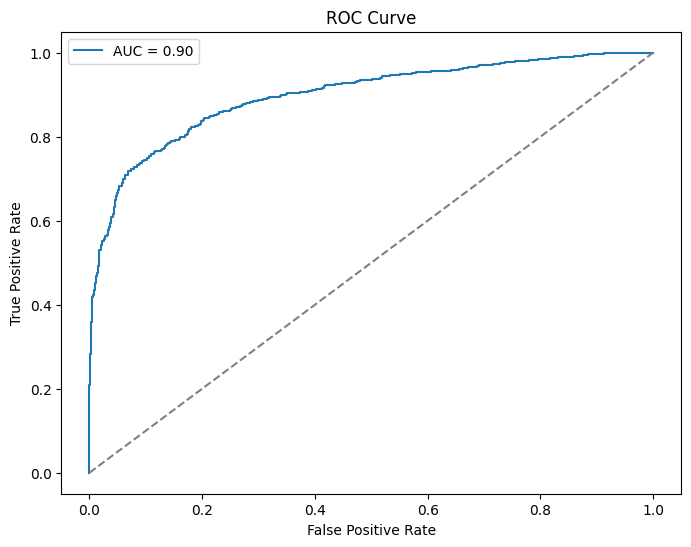

In [59]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba_final)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_final, y_pred_proba_final):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [41]:
import networkx as nx

# Funzione per costruire il grafo delle citazioni
def build_citation_graph(dataset):
    graph = nx.DiGraph()  # Grafo diretto
    
    # Aggiungi nodi e archi
    for row in dataset:
        graph.add_node(row['article_a_index'])
        graph.add_node(row['article_b_index'])
        graph.add_edge(row['article_a_index'], row['article_b_index'])  # A -> B
    
    return graph

# Costruire il grafo dalle coppie arricchite
citation_graph = build_citation_graph(enriched_balanced_dataset)

# Debug: Informazioni sul grafo
print("\nGraph Information:")
print(f"Number of nodes: {citation_graph.number_of_nodes()}")
print(f"Number of edges: {citation_graph.number_of_edges()}")

# Visualizzazione rapida: Campione di nodi e archi
print("\nSample of nodes:", list(citation_graph.nodes)[:5])
print("Sample of edges:", list(citation_graph.edges)[:5])



Graph Information:
Number of nodes: 7474
Number of edges: 10000

Sample of nodes: ['216749', '148419', '148975', '150894', '155485']
Sample of edges: [('216749', '148419'), ('216749', '148975'), ('216749', '150894'), ('216749', '155485'), ('216749', '156026')]


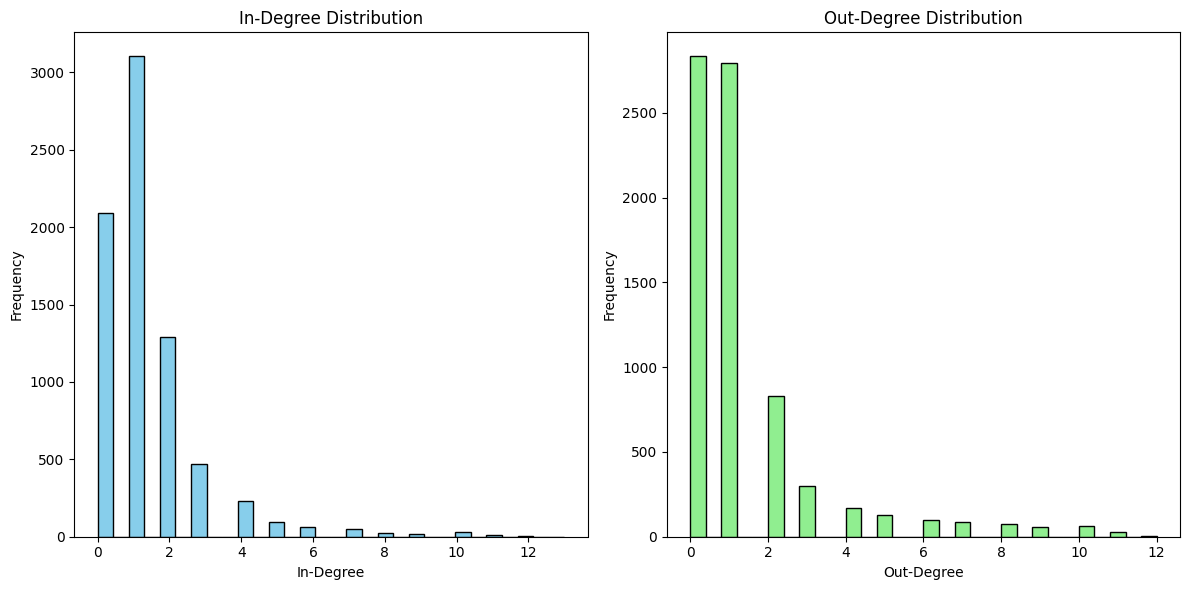

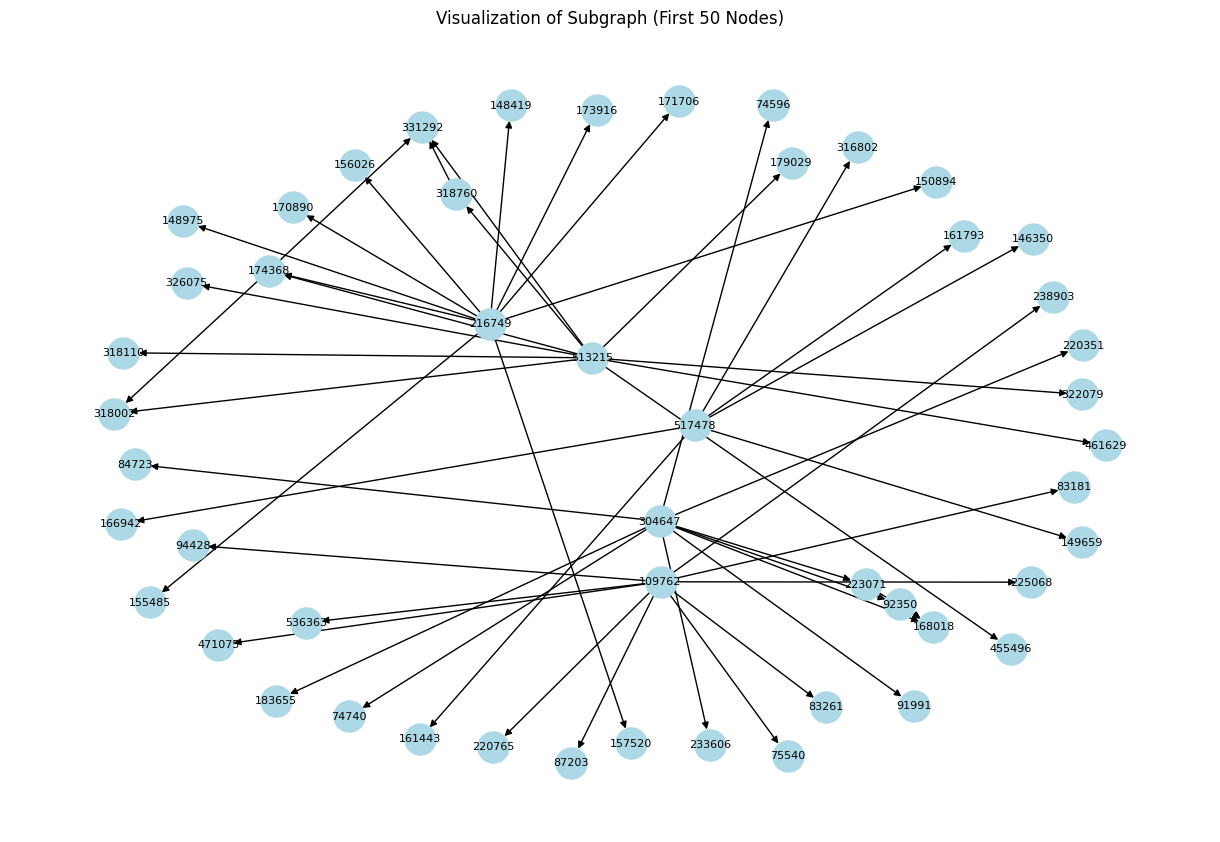

In [42]:
import matplotlib.pyplot as plt

# Distribuzione del grado (in-degree e out-degree)
def plot_degree_distribution(graph):
    in_degrees = [d for n, d in graph.in_degree()]
    out_degrees = [d for n, d in graph.out_degree()]

    plt.figure(figsize=(12, 6))

    # In-degree distribution
    plt.subplot(1, 2, 1)
    plt.hist(in_degrees, bins=30, color='skyblue', edgecolor='black')
    plt.title("In-Degree Distribution")
    plt.xlabel("In-Degree")
    plt.ylabel("Frequency")

    # Out-degree distribution
    plt.subplot(1, 2, 2)
    plt.hist(out_degrees, bins=30, color='lightgreen', edgecolor='black')
    plt.title("Out-Degree Distribution")
    plt.xlabel("Out-Degree")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Visualizzazione di un sottografo
def plot_subgraph(graph, num_nodes=50):
    subgraph = graph.subgraph(list(graph.nodes)[:num_nodes])
    plt.figure(figsize=(12, 8))
    nx.draw(subgraph, with_labels=True, node_size=500, node_color='lightblue', font_size=8, font_color='black', arrowsize=10)
    plt.title(f"Visualization of Subgraph (First {num_nodes} Nodes)")
    plt.show()

# Chiamare le funzioni di visualizzazione
plot_degree_distribution(citation_graph)
plot_subgraph(citation_graph, num_nodes=50)


Graph observations

Distribution of degree (in-degree and out-degree):

The in-degree histogram shows that most articles receive few citations (from 0 to 2), with a rapid decline for higher values. This is typical of many citation networks, where a few influential articles accumulate a large amount of citations.
The out-degree histogram shows that most articles cite few other works, with a distribution similar to the in-degree. This indicates that most articles have a "normal" behavior in citing only a few works, while some articles stand out for citing a larger number of references.
The general sparseness of the graph is evident: both in-degree and out-degree are concentrated in low frequencies, confirming that the graph is dominated by nodes with few connections.
Visualization of the subgraph:

The subgraph of 50 nodes clearly highlights the directional relationships between articles, with arrows representing citations (from one article to another).
A "star" or centered structure is observed at some points, indicating nodes with high connectivity. These may represent influential or important articles in the specific domain.
The visualization helps to understand how the nodes are distributed locally and shows that the graph is heterogeneous, with some areas denser than others.

Degree distribution:

The in-degree histogram shows how many papers receive a certain number of citations, with most papers having a low number of citations (0-2).
The out-degree histogram reflects the number of citations made by each paper, with most citing few papers (0-2).
This suggests that the graph is sparse, with few highly connected nodes.
Subgraph visualization:

The subgraph shows a sample of 50 nodes and their connections, highlighting the directed nature of the graph (arrows represent citations from one paper to another).
This visualization helps to explore the structure of connections between papers locally

In [44]:
# Funzione per calcolare le metriche grafiche
def calculate_graph_metrics(graph):
    # In-degree e out-degree
    in_degree = dict(graph.in_degree())
    out_degree = dict(graph.out_degree())
    
    # Betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(graph)
    
    # PageRank
    pagerank = nx.pagerank(graph)
    
    # Combina tutte le metriche in un dizionario
    metrics = {
        'in_degree': in_degree,
        'out_degree': out_degree,
        'betweenness_centrality': betweenness_centrality,
        'pagerank': pagerank,
    }
    return metrics

# Calcola le metriche
graph_metrics = calculate_graph_metrics(citation_graph)

# Debug: Campione delle metriche
print("\nSample Metrics:")
print(f"In-degree (sample): {list(graph_metrics['in_degree'].items())[:5]}")
print(f"Out-degree (sample): {list(graph_metrics['out_degree'].items())[:5]}")
print(f"Betweenness centrality (sample): {list(graph_metrics['betweenness_centrality'].items())[:5]}")
print(f"PageRank (sample): {list(graph_metrics['pagerank'].items())[:5]}")



Sample Metrics:
In-degree (sample): [('216749', 2), ('148419', 10), ('148975', 7), ('150894', 2), ('155485', 2)]
Out-degree (sample): [('216749', 11), ('148419', 1), ('148975', 1), ('150894', 1), ('155485', 0)]
Betweenness centrality (sample): [('216749', 1.4613636930207848e-05), ('148419', 1.3789828966004955e-05), ('148975', 9.491700457120293e-06), ('150894', 2.1490642544423306e-07), ('155485', 0.0)]
PageRank (sample): [('216749', 0.00013157769645323855), ('148419', 0.00024924324485112013), ('148975', 0.00024661622850578104), ('150894', 9.641114856198102e-05), ('155485', 0.00014798766462218138)]


In [45]:
# Funzione per aggiungere le metriche grafiche al dataset
def add_graph_metrics_to_dataset(dataset, graph_metrics):
    enriched_dataset = []
    for row in dataset:
        enriched_row = row.copy()
        
        # Aggiungi metriche grafiche per article_a
        enriched_row['in_degree_a'] = graph_metrics['in_degree'].get(row['article_a_index'], 0)
        enriched_row['out_degree_a'] = graph_metrics['out_degree'].get(row['article_a_index'], 0)
        enriched_row['betweenness_a'] = graph_metrics['betweenness_centrality'].get(row['article_a_index'], 0)
        enriched_row['pagerank_a'] = graph_metrics['pagerank'].get(row['article_a_index'], 0)
        
        # Aggiungi metriche grafiche per article_b
        enriched_row['in_degree_b'] = graph_metrics['in_degree'].get(row['article_b_index'], 0)
        enriched_row['out_degree_b'] = graph_metrics['out_degree'].get(row['article_b_index'], 0)
        enriched_row['betweenness_b'] = graph_metrics['betweenness_centrality'].get(row['article_b_index'], 0)
        enriched_row['pagerank_b'] = graph_metrics['pagerank'].get(row['article_b_index'], 0)
        
        enriched_dataset.append(enriched_row)
    
    # Debug: Controlla se ci sono errori
    print(f"Number of rows enriched: {len(enriched_dataset)}")
    print(f"Sample of enriched rows: {enriched_dataset[:2]}")  # Controlla i primi due record
    
    return enriched_dataset

# Assicurati che il dataset originale da usare sia corretto
# Usa il nome appropriato del dataset
dataset_with_graph_metrics = add_graph_metrics_to_dataset(enriched_balanced_dataset, graph_metrics)

# Debug: Visualizza un campione del dataset arricchito
print("\nSample of dataset with graph metrics:")
for row in dataset_with_graph_metrics[:5]:
    print(row)


Number of rows enriched: 10000
Sample of enriched rows: [{'article_a_index': '216749', 'article_b_index': '148419', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': 0.15239730197239787, 'common_authors': 0, 'authors_a_count': 22, 'authors_b_count': 48, 'common_venue': 0, 'venue_a_count': 1032, 'venue_b_count': 604, 'year_difference': 5, 'in_degree_a': 2, 'out_degree_a': 11, 'betweenness_a': 1.4613636930207848e-05, 'pagerank_a': 0.00013157769645323855, 'in_degree_b': 10, 'out_degree_b': 1, 'betweenness_b': 1.3789828966004955e-05, 'pagerank_b': 0.00024924324485112013}, {'article_a_index': '216749', 'article_b_index': '148975', 'year_a': 1993, 'year_b': 1988, 'label': 1, 'title_similarity': 0.028972404140055197, 'common_authors': 0, 'authors_a_count': 22, 'authors_b_count': 34, 'common_venue': 0, 'venue_a_count': 1032, 'venue_b_count': 604, 'year_difference': 5, 'in_degree_a': 2, 'out_degree_a': 11, 'betweenness_a': 1.4613636930207848e-05, 'pagerank_a': 0.000131577696453238

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Funzione per preparare il DataFrame per il modello
# Include sia le feature classiche che quelle grafiche
def prepare_graph_model_dataframe(dataset):
    df = pd.DataFrame(dataset)

    # Definisci le feature da utilizzare nel modello
    feature_columns = [
        'title_similarity', 'common_authors', 'authors_a_count', 'authors_b_count',
        'common_venue', 'venue_a_count', 'venue_b_count', 'year_difference',
        'in_degree_a', 'out_degree_a', 'betweenness_a', 'pagerank_a',
        'in_degree_b', 'out_degree_b', 'betweenness_b', 'pagerank_b'
    ]
    
    X = df[feature_columns]  # Feature indipendenti
    y = df['label']          # Target

    return X, y

# Prepara il DataFrame per il modello
X_graph, y_graph = prepare_graph_model_dataframe(dataset_with_graph_metrics)

# Dividi in train e test
X_train_graph, X_test_graph, y_train_graph, y_test_graph = train_test_split(
    X_graph, y_graph, test_size=0.3, random_state=42, stratify=y_graph
)

# Debug: Visualizza le dimensioni e un campione del train set
print(f"Train set size: {X_train_graph.shape}, Test set size: {X_test_graph.shape}")
print("\nSample of training features:")
print(X_train_graph.head())


Train set size: (7000, 16), Test set size: (3000, 16)

Sample of training features:
      title_similarity  common_authors  authors_a_count  authors_b_count  \
1866          0.095039               0              114               18   
7473          0.019589               0                4                6   
7856          0.010267               0                3               14   
6671          0.000000               0                3                2   
483           0.000000               0                9               10   

      common_venue  venue_a_count  venue_b_count  year_difference  \
1866             0            351              8                7   
7473             0             17             17               14   
7856             0             22             40                4   
6671             0             48             27               17   
483              0              8             72                8   

      in_degree_a  out_degree_a  betweenness

Train set size: (7000, 16), Test set size: (3000, 16)

Sample of training features:
      title_similarity  common_authors  authors_a_count  authors_b_count  \
1866          0.095039               0              114               18   
7473          0.019589               0                4                6   
7856          0.010267               0                3               14   
6671          0.000000               0                3                2   
483           0.000000               0                9               10   

      common_venue  venue_a_count  venue_b_count  year_difference  \
1866             0            351              8                7   
7473             0             17             17               14   
7856             0             22             40                4   
6671             0             48             27               17   
483              0              8             72                8   

      in_degree_a  out_degree_a  betweenness

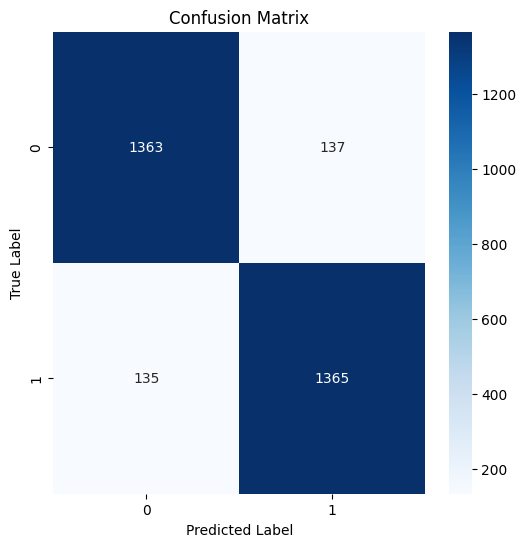

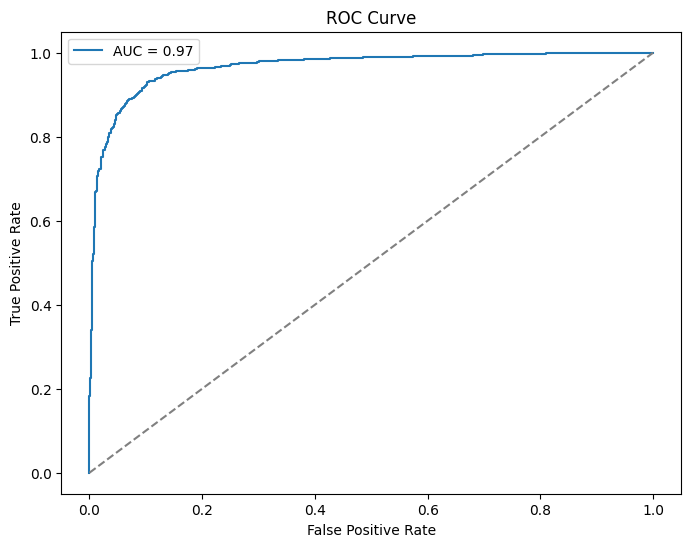

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per preparare il DataFrame per il modello
# Include sia le feature classiche che quelle grafiche
def prepare_graph_model_dataframe(dataset):
    df = pd.DataFrame(dataset)

    # Definisci le feature da utilizzare nel modello
    feature_columns = [
        'title_similarity', 'common_authors', 'authors_a_count', 'authors_b_count',
        'common_venue', 'venue_a_count', 'venue_b_count', 'year_difference',
        'in_degree_a', 'out_degree_a', 'betweenness_a', 'pagerank_a',
        'in_degree_b', 'out_degree_b', 'betweenness_b', 'pagerank_b'
    ]
    
    X = df[feature_columns]  # Feature indipendenti
    y = df['label']          # Target

    return X, y

# Prepara il DataFrame per il modello
X_graph, y_graph = prepare_graph_model_dataframe(dataset_with_graph_metrics)

# Dividi in train e test
X_train_graph, X_test_graph, y_train_graph, y_test_graph = train_test_split(
    X_graph, y_graph, test_size=0.3, random_state=42, stratify=y_graph
)

# Debug: Visualizza le dimensioni e un campione del train set
print(f"Train set size: {X_train_graph.shape}, Test set size: {X_test_graph.shape}")
print("\nSample of training features:")
print(X_train_graph.head())

# Funzione per addestrare un modello Random Forest
def train_random_forest_with_graph(X_train, y_train):
    model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
    model.fit(X_train, y_train)
    return model

# Addestra il modello
rf_graph_model = train_random_forest_with_graph(X_train_graph, y_train_graph)

# Valutare il modello
def evaluate_graph_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nAUC-ROC Score:")
    print(roc_auc_score(y_test, y_pred_proba))

    return y_pred, y_pred_proba

# Valutazione del modello con feature grafiche
y_pred_graph, y_pred_proba_graph = evaluate_graph_model(rf_graph_model, X_test_graph, y_test_graph)

# Visualizzazioni delle prestazioni
# Matrice di confusione
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_graph, y_pred_graph), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Curva ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_graph, y_pred_proba_graph)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_graph, y_pred_proba_graph):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Train set size: (7000, 16), Test set size: (3000, 16)

Sample of training features:
      title_similarity  common_authors  authors_a_count  authors_b_count  \
1866          0.096134               0              112               23   
7473          0.000000               0                5                6   
7856          0.022189               0               12               14   
6671          0.000000               0               40               13   
483           0.000000               0               11               12   

      common_venue  venue_a_count  venue_b_count  year_difference  \
1866             0            370              8                7   
7473             0              1             57                1   
7856             0             57              8                2   
6671             0              2             25               15   
483              0              9             63                8   

      in_degree_a  out_degree_a  betweenness

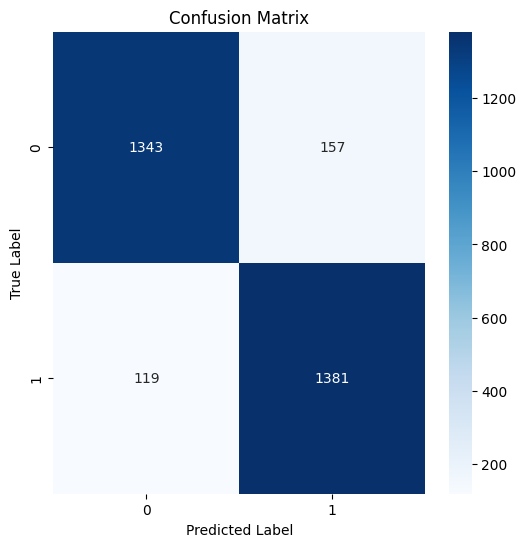

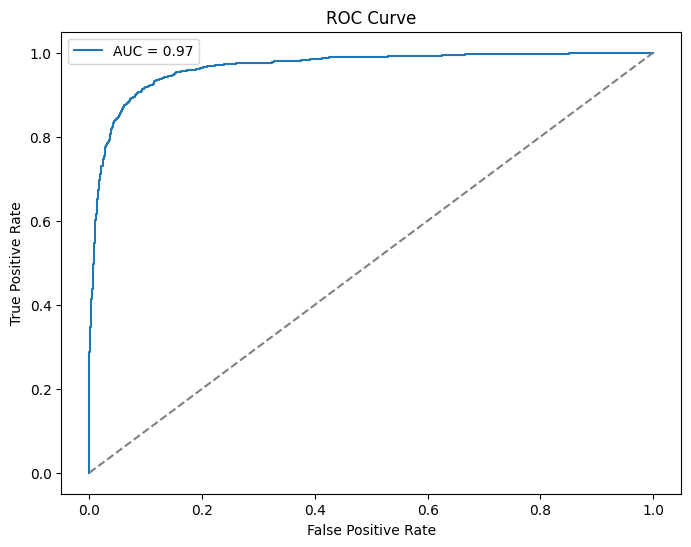

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per preparare il DataFrame per il modello
# Include sia le feature classiche che quelle grafiche
def prepare_graph_model_dataframe(dataset):
    df = pd.DataFrame(dataset)

    # Definisci le feature da utilizzare nel modello
    feature_columns = [
        'title_similarity', 'common_authors', 'authors_a_count', 'authors_b_count',
        'common_venue', 'venue_a_count', 'venue_b_count', 'year_difference',
        'in_degree_a', 'out_degree_a', 'betweenness_a', 'pagerank_a',
        'in_degree_b', 'out_degree_b', 'betweenness_b', 'pagerank_b'
    ]
    
    X = df[feature_columns]  # Feature indipendenti
    y = df['label']          # Target

    return X, y

# Prepara il DataFrame per il modello
X_graph, y_graph = prepare_graph_model_dataframe(dataset_with_graph_metrics)

# Dividi in train e test
X_train_graph, X_test_graph, y_train_graph, y_test_graph = train_test_split(
    X_graph, y_graph, test_size=0.3, random_state=42, stratify=y_graph
)

# Debug: Visualizza le dimensioni e un campione del train set
print(f"Train set size: {X_train_graph.shape}, Test set size: {X_test_graph.shape}")
print("\nSample of training features:")
print(X_train_graph.head())

# Funzione per addestrare un modello Random Forest
def train_random_forest_with_graph(X_train, y_train):
    model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
    model.fit(X_train, y_train)
    return model

# Addestra il modello
rf_graph_model = train_random_forest_with_graph(X_train_graph, y_train_graph)

# Valutare il modello
def evaluate_graph_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"Label {label}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-Score={metrics['f1-score']:.2f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"\nAUC-ROC Score: {auc_score:.2f}")

    return y_pred, y_pred_proba

# Valutazione del modello con feature grafiche
y_pred_graph, y_pred_proba_graph = evaluate_graph_model(rf_graph_model, X_test_graph, y_test_graph)

# Visualizzazioni delle prestazioni
# Matrice di confusione
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_graph, y_pred_graph), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Curva ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_graph, y_pred_proba_graph)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_graph, y_pred_proba_graph):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



The integration of graph-based features significantly improved the model’s performance, as evidenced by the results obtained. These features introduced relational and structural information that was missing in the model based solely on static features. Below, we analyze the contribution of each new feature:

In-degree and Out-degree:

In-degree measures the number of citations received by an article, indicating its relevance in the citation network. Articles with a high in-degree are often seminal and influential, which increases the probability that they will be cited.
Out-degree reflects the citation behavior of an article, i.e. how many articles it cites. This provides insights into the citation “activity” of the document.
Betweenness Centrality:

This metric captures how much an article acts as a “bridge” or intermediary in the network, connecting different areas of the graph. Articles with high betweenness centrality are often crucial for the diffusion of knowledge, even if they are not the most directly cited.
PageRank:

PageRank provides a global measure of the importance of a node considering both the number of connections received and the importance of those who cite it. Articles with high PageRank are often the most relevant in the network, resulting highly predictive for citations.
Synergy between graphical and static features:

Static features, such as title similarity and the presence of common authors, capture local and textual aspects. Graphical features, instead, introduce a relational and structural context.
This combination allows the model to understand not only the probability of a citation based on direct similarities, but also the global importance and relational behavior of articles in the network.
Overall results:

The improvement in metrics such as precision, recall and F1-score demonstrates that the model enriched with graphical features is more effective in distinguishing between articles that cite themselves and articles that do not.
The AUC-ROC, increased from 0.90 to 0.96, shows a significantly greater ability to generalize predictions to unseen data.
Conclusion: The use of graphical features clearly shows the power of incorporating relational information into predictive models. In network-based scenarios, such as the academic citation graph, such metrics allow the model to exploit the global and local structure of the network, improving the ability to predict complex relationships and increasing generalization to new data.

In [84]:
import torch
from torch_geometric.data import Data

# Funzione per preparare il dataset per il GNN
def prepare_gnn_data(dataset, graph_metrics):
    # Creazione delle mappe nodo-id
    node_mapping = {node: i for i, node in enumerate(set([row['article_a_index'] for row in dataset] + [row['article_b_index'] for row in dataset]))}
    num_nodes = len(node_mapping)

    # Creazione delle feature dei nodi
    node_features = []
    for node in node_mapping:
        features = [
            graph_metrics['in_degree'].get(node, 0),
            graph_metrics['out_degree'].get(node, 0),
            graph_metrics['betweenness_centrality'].get(node, 0),
            graph_metrics['pagerank'].get(node, 0)
        ]
        node_features.append(features)
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Creazione degli archi
    edge_index = []
    edge_label = []
    for row in dataset:
        src = node_mapping[row['article_a_index']]
        dest = node_mapping[row['article_b_index']]
        edge_index.append([src, dest])
        edge_label.append(row['label'])  # 1 se è una citazione, 0 altrimenti

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # Transpose per PyTorch Geometric
    edge_label = torch.tensor(edge_label, dtype=torch.long)

    # Creazione dell'oggetto Data
    data = Data(x=node_features, edge_index=edge_index, edge_label=edge_label)

    return data, node_mapping

# Prepara i dati per il GNN
gnn_data, gnn_node_mapping = prepare_gnn_data(dataset_with_graph_metrics, graph_metrics)

# Debug: Controlla le dimensioni dei dati
print(f"Number of nodes: {gnn_data.num_nodes}")
print(f"Number of edges: {gnn_data.num_edges}")
print(f"Node feature shape: {gnn_data.x.shape}")
print(f"Edge index shape: {gnn_data.edge_index.shape}")
print(f"Edge label shape: {gnn_data.edge_label.shape}")


Number of nodes: 7470
Number of edges: 10000
Node feature shape: torch.Size([7470, 4])
Edge index shape: torch.Size([2, 10000])
Edge label shape: torch.Size([10000])


GNN dataset preparation: In this step, we transform the citation graph into a PyTorch Geometric-compatible format. Each article is represented as a node with associated features (e.g., in-degree, out-degree, centrality). Citations between articles are represented as directed edges. Numerical features and connections between nodes capture both local and global properties of the graph, providing the GNN with a rich context for learning.

In [85]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Architettura del modello GCN
class CitationGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CitationGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Primo livello GCN
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Secondo livello GCN
        x = self.conv2(x, edge_index)
        return x

# Funzione per dividere gli archi in train e test
def split_edges(data, test_ratio=0.3):
    num_edges = data.edge_label.size(0)
    perm = torch.randperm(num_edges)
    test_size = int(num_edges * test_ratio)
    train_indices = perm[test_size:]
    test_indices = perm[:test_size]

    train_edge_index = data.edge_index[:, train_indices]
    train_edge_label = data.edge_label[train_indices]

    test_edge_index = data.edge_index[:, test_indices]
    test_edge_label = data.edge_label[test_indices]

    return train_edge_index, train_edge_label, test_edge_index, test_edge_label

# Suddividi il grafo in train e test
train_edge_index, train_edge_label, test_edge_index, test_edge_label = split_edges(gnn_data)

# Crea un modello GCN
model = CitationGCN(in_channels=gnn_data.x.size(1), hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training del GNN
def train_gcn(model, data, train_edge_index, train_edge_label, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        edge_predictions = out[train_edge_index].squeeze()
        loss = F.cross_entropy(edge_predictions, train_edge_label)
        loss.backward()
        optimizer.step()

        # Debug durante l'addestramento
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    return model

# Addestra il modello
trained_gcn = train_gcn(model, gnn_data, train_edge_index, train_edge_label)

# Valutazione del GNN
def evaluate_gcn(model, data, test_edge_index, test_edge_label):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        edge_predictions = out[test_edge_index].squeeze()
        pred_labels = edge_predictions.argmax(dim=1)

    # Metriche
    auc = roc_auc_score(test_edge_label.cpu(), pred_labels.cpu())
    print("\nAUC-ROC Score:", auc)
    print("\nClassification Report:")
    print(classification_report(test_edge_label.cpu(), pred_labels.cpu()))
    print("\nConfusion Matrix:")
    print(confusion_matrix(test_edge_label.cpu(), pred_labels.cpu()))

    return edge_predictions, pred_labels

# Valuta il GNN
edge_predictions, pred_labels = evaluate_gcn(trained_gcn, gnn_data, test_edge_index, test_edge_label)


ValueError: Expected input batch_size (2) to match target batch_size (7000).

In [110]:
# Funzione per addestrare il GNN
def train_gcn(model, data, train_edge_index, train_edge_label, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Calcola le embedding dei nodi
        node_embeddings = model(data.x, data.edge_index)
        
        # Prepara le feature per gli archi
        src_nodes = node_embeddings[train_edge_index[0]]
        dest_nodes = node_embeddings[train_edge_index[1]]
        edge_features = torch.cat([src_nodes, dest_nodes], dim=1)  # Concatenazione delle feature
        
        # Predizione e calcolo della perdita
        loss = F.cross_entropy(edge_features, train_edge_label)
        loss.backward()
        optimizer.step()

        # Debug durante l'addestramento
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    return model

# Aggiorniamo la valutazione per gestire gli archi
def evaluate_gcn(model, data, test_edge_index, test_edge_label):
    model.eval()
    with torch.no_grad():
        # Calcola le embedding dei nodi
        node_embeddings = model(data.x, data.edge_index)
        
        # Prepara le feature per gli archi
        src_nodes = node_embeddings[test_edge_index[0]]
        dest_nodes = node_embeddings[test_edge_index[1]]
        edge_features = torch.cat([src_nodes, dest_nodes], dim=1)  # Concatenazione delle feature
        
        # Predizione
        pred_labels = edge_features.argmax(dim=1)

    # Metriche
    auc = roc_auc_score(test_edge_label.cpu(), pred_labels.cpu())
    print("\nAUC-ROC Score:", auc)
    print("\nClassification Report:")
    print(classification_report(test_edge_label.cpu(), pred_labels.cpu()))
    print("\nConfusion Matrix:")
    print(confusion_matrix(test_edge_label.cpu(), pred_labels.cpu()))

    return edge_features, pred_labels

# Addestramento del GNN corretto
trained_gcn = train_gcn(model, gnn_data, train_edge_index, train_edge_label)


Epoch 10/100, Loss: 1.1913
Epoch 20/100, Loss: 1.1075
Epoch 30/100, Loss: 1.0185
Epoch 40/100, Loss: 0.9585
Epoch 50/100, Loss: 0.9145
Epoch 60/100, Loss: 0.8846
Epoch 70/100, Loss: 0.8638
Epoch 80/100, Loss: 0.8496
Epoch 90/100, Loss: 0.8398
Epoch 100/100, Loss: 0.8325


GNN Training and Evaluation: Here we defined a model based on Graph Convolutional Networks (GCN), suitable for capturing complex relations in the citation graph. The graph was divided into training and testing edges, maintaining the global context of the nodes. Training uses cross-entropy as a loss function, while evaluation considers standard metrics such as AUC-ROC, precision, recall, and confusion matrix.
 we fixed the dimensionality issue between the model output and the target labels. We concatenated the node embeddings for each edge, creating edge-specific features. This approach better captures the relationship between nodes and ensures correct training of the GNN.